# Dog Breed Classification using Neural Networks

This notebook implements a deep learning solution for classifying dog breeds from images. We'll use PyTorch to build and train neural networks that can identify 70 different dog breeds from the provided dataset.

## Project Overview
- Dataset: 224 x 224 x 3 color images of 70 different dog breeds
- Task: Create a neural network to classify images by dog breed
- Evaluation: Accuracy on a test set of 200 images (split into public/private leaderboards)
- Goal: Maximize classification accuracy through effective model design and training

## 1. Setup and Import Libraries

Import necessary libraries and set up environment variables. We'll use PyTorch for deep learning, along with supporting libraries for data processing and visualization.

In [1]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import utils
import torch
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="The verbose parameter is deprecated", category=UserWarning)
warnings.filterwarnings("ignore", message="Recall is ill-defined and being set to 0.0", category=UserWarning)

### 1.1 Set Random Seed and Initialize Device

Setting a random seed ensures reproducibility of results. We'll also check if a GPU is available for faster training.

In [2]:
utils.set_seed(42)
device = utils.get_device()

Random seed set to 42
Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory allocated: 0.00 MB
Memory cached: 0.00 MB


## 2. Data Loading and Exploration

First, we'll load the dataset from train_val.csv and test.csv files. This step will give us an overview of the data distribution and structure.

### 2.1 Load Training, Validation, and Test Datasets

We'll load the data from CSV files and examine a sample of each dataset.

In [3]:
train_df, valid_df, test_df, classes = utils.load_data_info(base_dir='dogs_data')

print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(valid_df)}")
print(f"Number of test samples: {len(test_df)}")
print(f"Number of dog breed classes: {len(classes)}")

print("\nTraining data sample:")
display(train_df.head())

print("\nValidation data sample:")
display(valid_df.head())

print("\nTest data sample:")
display(test_df.head())

Train samples: 7946
Validation samples: 700
Test samples: 200
Number of classes: 70
Number of training samples: 7946
Number of validation samples: 700
Number of test samples: 200
Number of dog breed classes: 70

Training data sample:


filepaths  labels data set
0  train/Afghan/001.jpg  Afghan    train
1  train/Afghan/002.jpg  Afghan    train
2  train/Afghan/003.jpg  Afghan    train
3  train/Afghan/004.jpg  Afghan    train
4  train/Afghan/005.jpg  Afghan    train


Validation data sample:


filepaths  labels data set
7946  valid/Afghan/01.jpg  Afghan    valid
7947  valid/Afghan/02.jpg  Afghan    valid
7948  valid/Afghan/03.jpg  Afghan    valid
7949  valid/Afghan/04.jpg  Afghan    valid
7950  valid/Afghan/05.jpg  Afghan    valid


Test data sample:


Id       filepaths
0   1  test/08/05.jpg
1   2  test/02/03.jpg
2   3  test/15/07.jpg
3   4  test/09/08.jpg
4   5  test/16/04.jpg

### 2.2 Verify File Paths

It's important to check if all image files are accessible. This step will identify any missing files in our dataset.

In [4]:
utils.check_file_paths(train_df, base_dir='dogs_data', sample_size=100)
utils.check_file_paths(valid_df, base_dir='dogs_data', sample_size=100)
utils.check_file_paths(test_df, base_dir='dogs_data', filepath_col='filepaths', sample_size=100)

Checking files: 100%|██████████| 100/100 [00:00<00:00, 13309.76it/s]


Checked 100 files
Missing files: 0 (0.00%)


Checking files: 100%|██████████| 100/100 [00:00<00:00, 5370.08it/s]


Checked 100 files
Missing files: 0 (0.00%)


Checking files: 100%|██████████| 100/100 [00:00<00:00, 10506.25it/s]

Checked 100 files
Missing files: 0 (0.00%)


{'total_checked': 100,
 'missing_files': [],
 'missing_count': 0,
 'missing_percent': 0.0}

### 2.3 Analyze Class Distribution

Let's examine the distribution of dog breeds in our training set to identify any potential class imbalance.

Number of unique classes: 70
Most common class: ('Shih-Tzu', 198)
Least common class: ('American Hairless', 65)


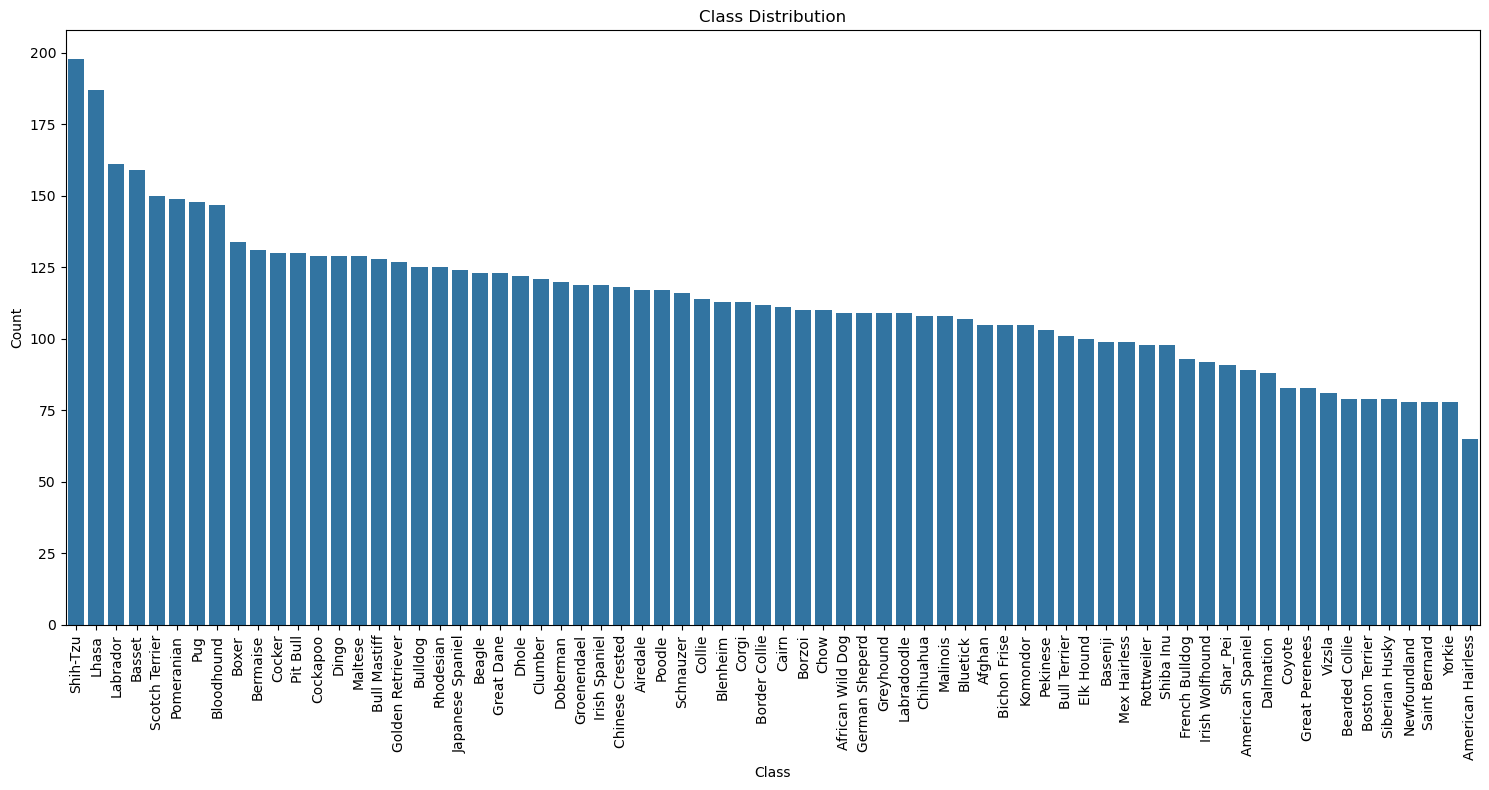

In [5]:
class_counts = utils.get_class_distribution(train_df)
print(f"Number of unique classes: {len(class_counts)}")
print(f"Most common class: {class_counts.most_common(1)[0]}")
print(f"Least common class: {class_counts.most_common()[-1]}")

utils.plot_class_distribution(class_counts, figsize=(15, 8), rot=90)

### 2.4 Detailed Analysis of Class Imbalance

We'll compute detailed metrics about class imbalance, including imbalance ratio and standard deviation of class sizes.

In [6]:
imbalance_metrics = utils.analyze_class_imbalance(train_df)

Total samples: 7946
Number of classes: 70
Minimum samples per class: 65
Maximum samples per class: 198
Imbalance ratio (max/min): 3.05
Mean samples per class: 113.51
Standard deviation: 24.68


### 2.5 Explore Image Properties

Let's examine the properties of images in our dataset, such as dimensions and file sizes.

In [7]:
image_properties = utils.explore_image_properties(train_df, base_dir='dogs_data', sample_size=50)

print(f"Most common image dimensions: {image_properties['common_dims']}")
print(f"Average file size: {image_properties['avg_file_size']:.2f} KB")
print(f"Min file size: {image_properties['min_file_size']:.2f} KB")
print(f"Max file size: {image_properties['max_file_size']:.2f} KB")

Exploring images: 100%|██████████| 50/50 [00:00<00:00, 212.91it/s]

Most common image dimensions: [((224, 224), 50)]
Average file size: 23.60 KB
Min file size: 12.57 KB
Max file size: 35.88 KB


### 2.6 Visualize Sample Images

Let's visualize some sample images from different breed classes to better understand the data.

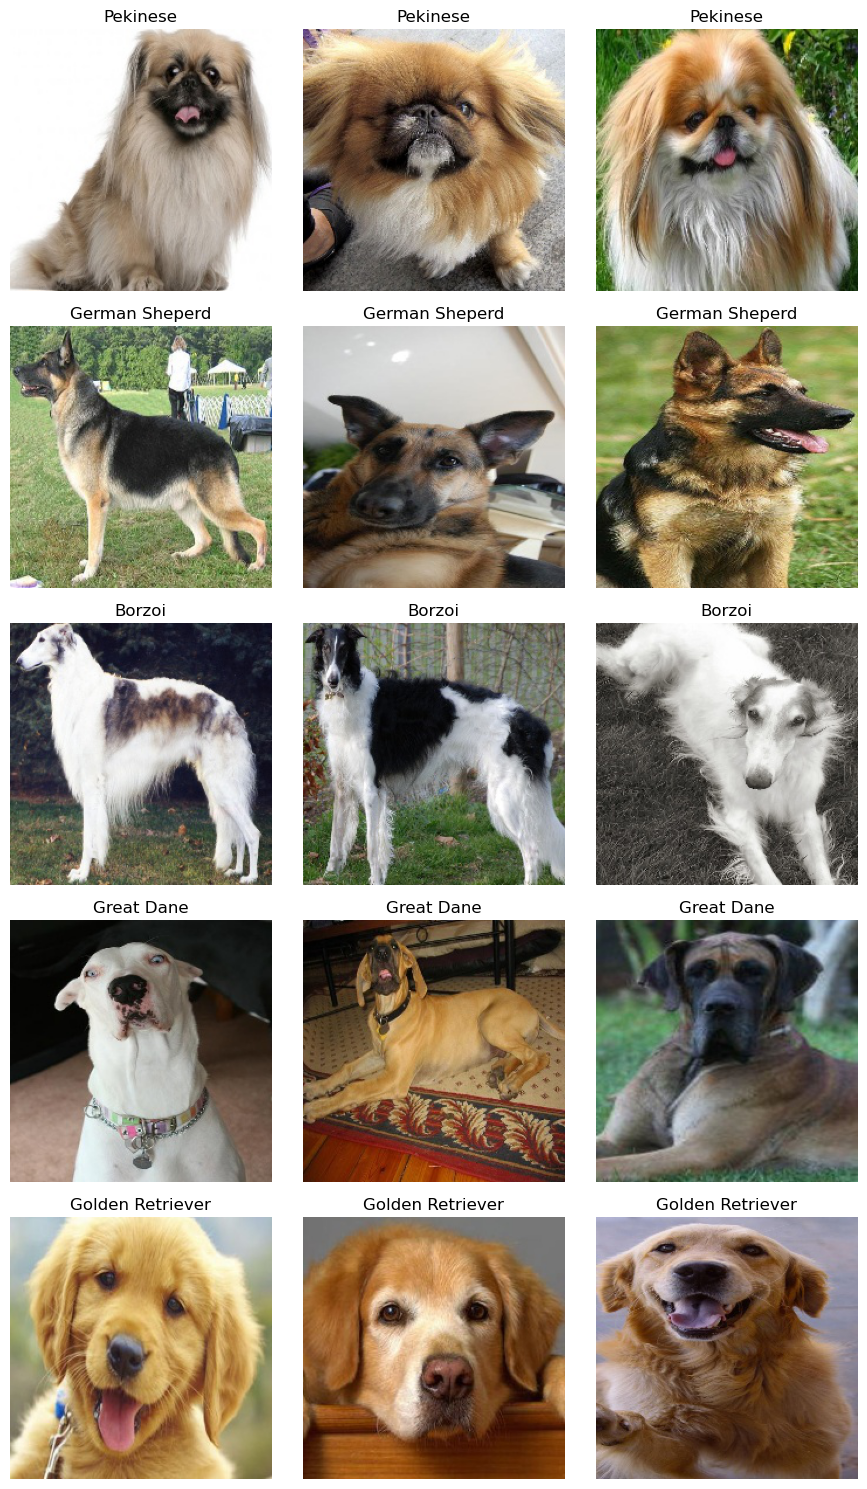

In [8]:
utils.visualize_sample_images(train_df, base_dir='dogs_data', num_classes=5, samples_per_class=3)

## 3. Data Preparation

Now we'll prepare the data for model training. This includes defining transformations for data augmentation, normalizing pixel values, and creating DataLoader objects.

### 3.1 Define Data Transformations

We'll create transformations for training (with augmentation) and validation (without augmentation) data.

In [9]:
train_transform, val_transform = utils.get_data_transforms(img_size=224, augment=True)

print("Training transforms:")
print(train_transform)
print("\nValidation transforms:")
print(val_transform)

Training transforms:
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Validation transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### 3.2 Visualize Data Augmentation

Let's visualize how our augmentation transforms affect the images. This helps ensure our augmentations are reasonable.

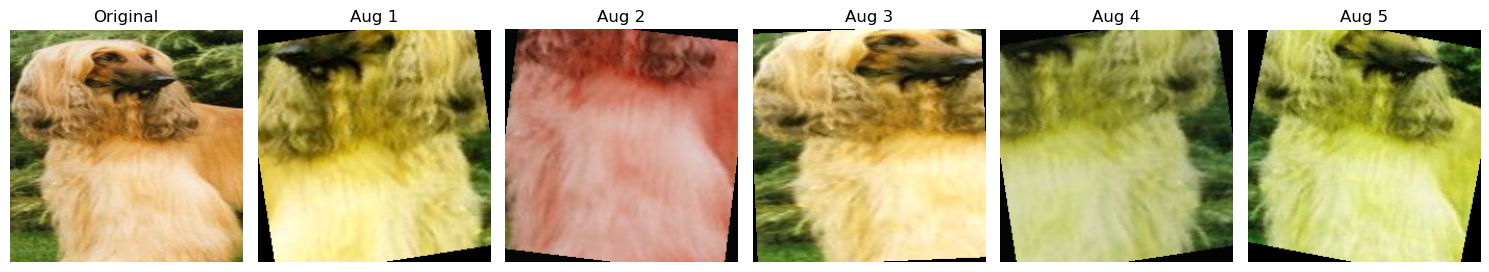

In [10]:
sample_row = train_df.iloc[0]
sample_image_path = os.path.join('dogs_data', sample_row['filepaths'])

utils.visualize_augmentations(sample_image_path, train_transform, num_augmentations=5)

### 3.3 Create DataLoaders

We'll create PyTorch DataLoader objects for efficient batched loading of data during training and evaluation.

In [11]:
dataloaders = utils.create_dataloaders(
    train_df, 
    valid_df, 
    test_df, 
    base_dir='dogs_data',
    batch_size=32,
    img_size=224,
    num_workers=4,
    augment=True
)

train_loader = dataloaders['train_loader']
valid_loader = dataloaders['valid_loader']
test_loader = dataloaders['test_loader']
classes = dataloaders['classes']
class_to_idx = dataloaders['class_to_idx']
idx_to_class = dataloaders['idx_to_class']

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(valid_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in training loader: 249
Number of batches in validation loader: 22
Number of batches in test loader: 7


### 3.4 Inspect a Batch of Training Data

Let's examine a batch of data to verify the format and content before training.

In [12]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label examples: {labels[:5]}")

label_names = [idx_to_class[idx.item()] for idx in labels[:5]]
print(f"Label names: {label_names}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Label examples: tensor([17, 35, 12, 49, 52])
Label names: ['Boxer', 'Elk Hound', 'Bloodhound', 'Lhasa', 'Mex Hairless']


## 4. Model Architecture

We'll use transfer learning with pre-trained models, as this approach typically yields good results for image classification tasks. Initially, we'll freeze the base layers and only train the classifier head.

### 4.1 Create Main Model

We'll create our first model using ResNet-50 architecture with transfer learning. This model will serve as a strong baseline.

In [13]:
model = utils.create_model(
    model_name='resnet50',
    num_classes=len(classes),
    pretrained=True,
    freeze_base=True
)

trainable_params = utils.count_parameters(model)
model_size_mb = utils.calculate_model_size(model)

Trainable parameters: 143,430 (0.61% of total)
Total parameters: 23,651,462
Model size: 90.43 MB


### 4.2 Display Model Summary

Let's view the model architecture and parameter details.

In [14]:
utils.summary(model, (3, 224, 224))

Model Structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### 4.3 Estimate Training Time

Let's estimate how long training will take to plan our resources accordingly.

In [15]:
time_estimates = utils.estimate_training_time(
    model, 
    train_loader, 
    device=device,
    num_epochs=10,  
    num_batches=10  
)

Estimating training time: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


Average batch time: 0.0566 seconds
Estimated time per epoch: 14.09 seconds (0.23 minutes)
Estimated total training time for 10 epochs: 140.89 seconds (2.35 minutes)


## 5. Training Setup

Configure loss function, optimizer, and learning rate scheduler. We'll use class weights to address any class imbalance and an Adam optimizer for efficient training.

### 5.1 Set Up Loss Function, Optimizer, and Learning Rate Scheduler

We'll use cross-entropy loss with class weights to handle class imbalance, Adam optimizer for efficient training, and a learning rate scheduler to reduce the learning rate when validation performance plateaus.

In [16]:
weights_dict = utils.calculate_class_weights(train_df, method='inverse')
class_weights = weights_dict['tensor_weights'].to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

### 5.2 Find Optimal Learning Rate

We'll use a learning rate finder to determine the optimal initial learning rate for our model.

Finding learning rate:  40%|████      | 100/249 [00:25<00:37,  3.99it/s]


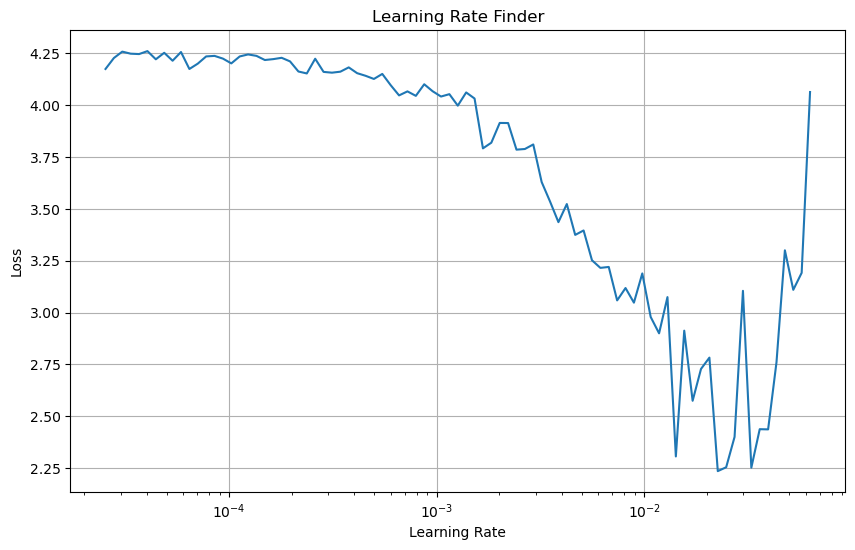

In [17]:
lr_finder, plot_lr = utils.create_learning_rate_finder(model, train_loader, criterion, optimizer, device)
lr_results = lr_finder(start_lr=1e-5, end_lr=1e-1, num_iterations=100)
plot_lr(lr_results, skip_start=10, skip_end=5)

## 6. Model Training and Validation - Initial Training Phase

The first training phase will train only the classifier head while keeping the backbone frozen. This approach allows us to leverage the pre-trained weights effectively.

### 6.1 Initial Training Phase

We'll train the model for up to 15 epochs with early stopping if validation performance doesn't improve for 5 consecutive epochs.

In [18]:
os.makedirs('model_data', exist_ok=True)
checkpoint_path = 'model_data/best_dog_breed_model.pth'

model, history = utils.train_or_load_model(
    model,
    {'train_loader': train_loader, 'valid_loader': valid_loader},
    criterion,
    optimizer,
    num_epochs=15,
    scheduler=scheduler,
    device=device,
    early_stopping=5,
    checkpoint_path=checkpoint_path,
    force_train=False
)

Epoch 1/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.69it/s]


train Loss: 13.5659 Acc: 0.4196


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.33s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]


val Loss: 2.2437 Acc: 0.8314
Saved best model with accuracy 0.8314

Epoch 2/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.69it/s]


train Loss: 14.1803 Acc: 0.5354


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.36s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]


val Loss: 2.8206 Acc: 0.8729
Saved best model with accuracy 0.8729

Epoch 3/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.73it/s]


train Loss: 14.3522 Acc: 0.5715


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:23,  1.26s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]


val Loss: 2.5935 Acc: 0.8871
Saved best model with accuracy 0.8871

Epoch 4/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.78it/s]


train Loss: 14.4680 Acc: 0.5950


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:26,  1.42s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]


val Loss: 2.3286 Acc: 0.8843
No improvement for 1 epochs

Epoch 5/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.69it/s]


train Loss: 14.3523 Acc: 0.6158


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:26,  1.37s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]


val Loss: 2.8058 Acc: 0.8914
Saved best model with accuracy 0.8914

Epoch 6/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.72it/s]


train Loss: 11.1432 Acc: 0.6705


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:26,  1.38s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]


val Loss: 2.0400 Acc: 0.9229
Saved best model with accuracy 0.9229

Epoch 7/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.73it/s]


train Loss: 9.2519 Acc: 0.6846


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.32s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]


val Loss: 1.9495 Acc: 0.9200
No improvement for 1 epochs

Epoch 8/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.73it/s]


train Loss: 8.6571 Acc: 0.6961


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.35s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]


val Loss: 2.2039 Acc: 0.9357
Saved best model with accuracy 0.9357

Epoch 9/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.72it/s]


train Loss: 8.8077 Acc: 0.6958


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:27,  1.42s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]


val Loss: 1.9863 Acc: 0.9214
No improvement for 1 epochs

Epoch 10/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.70it/s]


train Loss: 7.6896 Acc: 0.7110


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.36s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]


val Loss: 1.9833 Acc: 0.9314
No improvement for 2 epochs

Epoch 11/15
----------


train: 100%|██████████| 249/249 [00:31<00:00,  7.84it/s]


train Loss: 7.3947 Acc: 0.7167


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.30s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.27it/s]


val Loss: 2.0003 Acc: 0.9229
No improvement for 3 epochs

Epoch 12/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.59it/s]


train Loss: 7.5301 Acc: 0.7102


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:26,  1.40s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]


val Loss: 1.5627 Acc: 0.9243
No improvement for 4 epochs

Epoch 13/15
----------


train: 100%|██████████| 249/249 [00:32<00:00,  7.73it/s]


train Loss: 7.3608 Acc: 0.7074


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.30s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.27it/s]

val Loss: 1.5668 Acc: 0.9257
No improvement for 5 epochs
Early stopping after 5 epochs without improvement
Training complete in 8m 30s
Best val Acc: 0.9357


### 6.2 Visualize Training History

Let's plot the training and validation loss and accuracy to analyze model convergence.

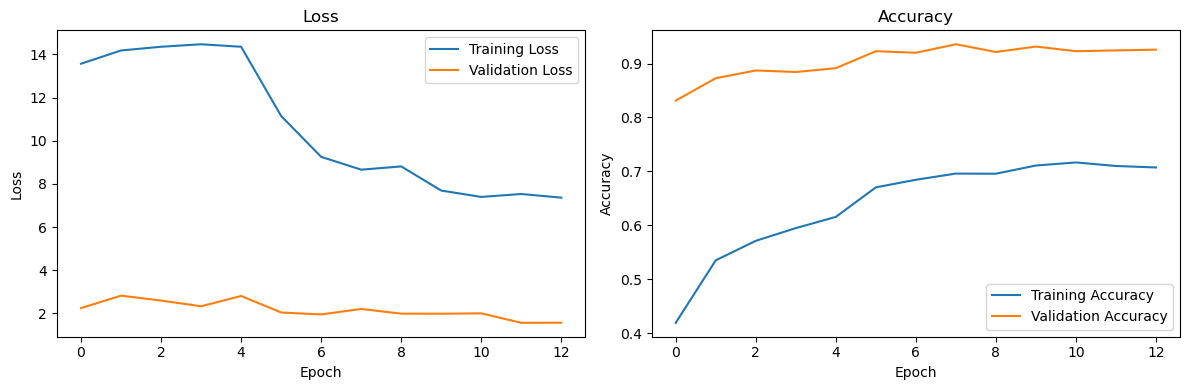

In [19]:
utils.plot_training_history(history)

## 7. Fine-tuning - Unfreezing Deeper Layers

After the initial training phase, we'll unfreeze some deeper layers of the network and continue training with a lower learning rate. This fine-tuning process allows the model to adapt the pre-trained features to our specific dog breed dataset.

### 7.1 Unfreeze Deeper Layers

We'll unfreeze the 'layer4' and 'fc' layers of the ResNet model to allow further adaptation to our specific dataset.

In [20]:
model = utils.unfreeze_layers(model, ['layer4', 'fc'])
utils.count_parameters(model)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

Trainable parameters: 15,108,166 (63.88% of total)
Total parameters: 23,651,462


### 7.2 Fine-tune the Model

We'll continue training the model with the unfrozen layers, using a lower learning rate to avoid catastrophic forgetting.

In [21]:
fine_tune_path = 'model_data/fine_tuned_dog_breed_model.pth'

fine_tuned_model, ft_history = utils.train_or_load_model(
    model,
    {'train_loader': train_loader, 'valid_loader': valid_loader},
    criterion,
    optimizer,
    num_epochs=10,
    scheduler=scheduler,
    device=device,
    early_stopping=5,
    checkpoint_path=fine_tune_path,
    force_train=False
)

Epoch 1/10
----------


train: 100%|██████████| 249/249 [00:36<00:00,  6.86it/s]


train Loss: 4.2666 Acc: 0.6925


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.30s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]


val Loss: 1.0440 Acc: 0.9200
Saved best model with accuracy 0.9200

Epoch 2/10
----------


train: 100%|██████████| 249/249 [00:36<00:00,  6.86it/s]


train Loss: 2.3401 Acc: 0.6854


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.33s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]


val Loss: 0.5620 Acc: 0.9114
No improvement for 1 epochs

Epoch 3/10
----------


train: 100%|██████████| 249/249 [00:36<00:00,  6.86it/s]


train Loss: 1.7091 Acc: 0.6772


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.37s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.14it/s]


val Loss: 0.4695 Acc: 0.9114
No improvement for 2 epochs

Epoch 4/10
----------


train: 100%|██████████| 249/249 [00:36<00:00,  6.84it/s]


train Loss: 1.4608 Acc: 0.6918


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:26,  1.41s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.07it/s]


val Loss: 0.5173 Acc: 0.9129
No improvement for 3 epochs

Epoch 5/10
----------


train: 100%|██████████| 249/249 [00:36<00:00,  6.86it/s]


train Loss: 1.3033 Acc: 0.6968


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.35s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]


val Loss: 0.4149 Acc: 0.9071
No improvement for 4 epochs

Epoch 6/10
----------


train: 100%|██████████| 249/249 [00:36<00:00,  6.88it/s]


train Loss: 1.2058 Acc: 0.7015


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.36s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]

val Loss: 0.3724 Acc: 0.9114
No improvement for 5 epochs
Early stopping after 5 epochs without improvement
Training complete in 4m 20s
Best val Acc: 0.9200


### 7.3 Analyze Fine-tuning Performance

Let's visualize the training and validation metrics during fine-tuning to see if performance improved.

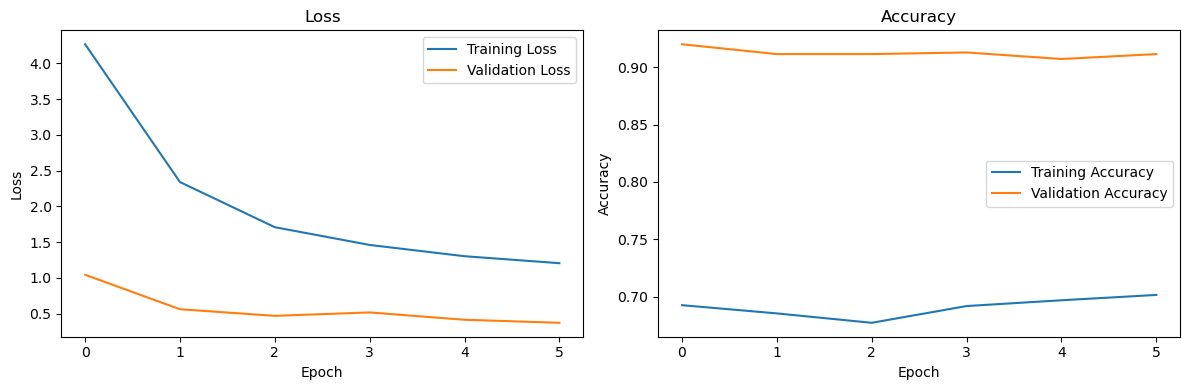

In [22]:
utils.plot_training_history(ft_history)

## 8. Model Evaluation

Now we'll evaluate our fine-tuned model on the validation set to understand its performance across different classes and identify potential areas for improvement.

### 8.1 Evaluate Model on Validation Set

We'll compute detailed metrics including accuracy, loss, and per-class performance.

In [23]:
eval_results = utils.evaluate_model(
    fine_tuned_model,
    valid_loader,
    criterion,
    device=device,
    classes=classes
)

print(f"Validation accuracy: {eval_results['accuracy']:.4f}")
print(f"Validation loss: {eval_results['loss']:.4f}")

Model output classes: 70


Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:  14%|█▎        | 3/22 [00:05<00:25,  1.35s/it]

Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]

Loss: 1.0440, Accuracy: 0.9200
                   precision    recall  f1-score   support

           Afghan       1.00      0.50      0.67        20
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      0.90      0.95        10
American Hairless       1.00      0.80      0.89        10
 American Spaniel       0.00      0.00      0.00         0
          Basenji       0.91      1.00      0.95        10
           Basset       1.00      1.00      1.00        10
           Beagle       1.00      1.00      1.00        10
   Bearded Collie       1.00      0.90      0.95        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       1.00      1.00      1.00        10
       Bloodhound       1.00      1.00      1.00        10
         Bluetick       0.91      1.00      0.95        10
    Border Collie       1.00      0.90      0.95        10
           Borzoi       

### 8.2 Visualize Model Predictions

Let's visualize some sample predictions to qualitatively assess model performance.

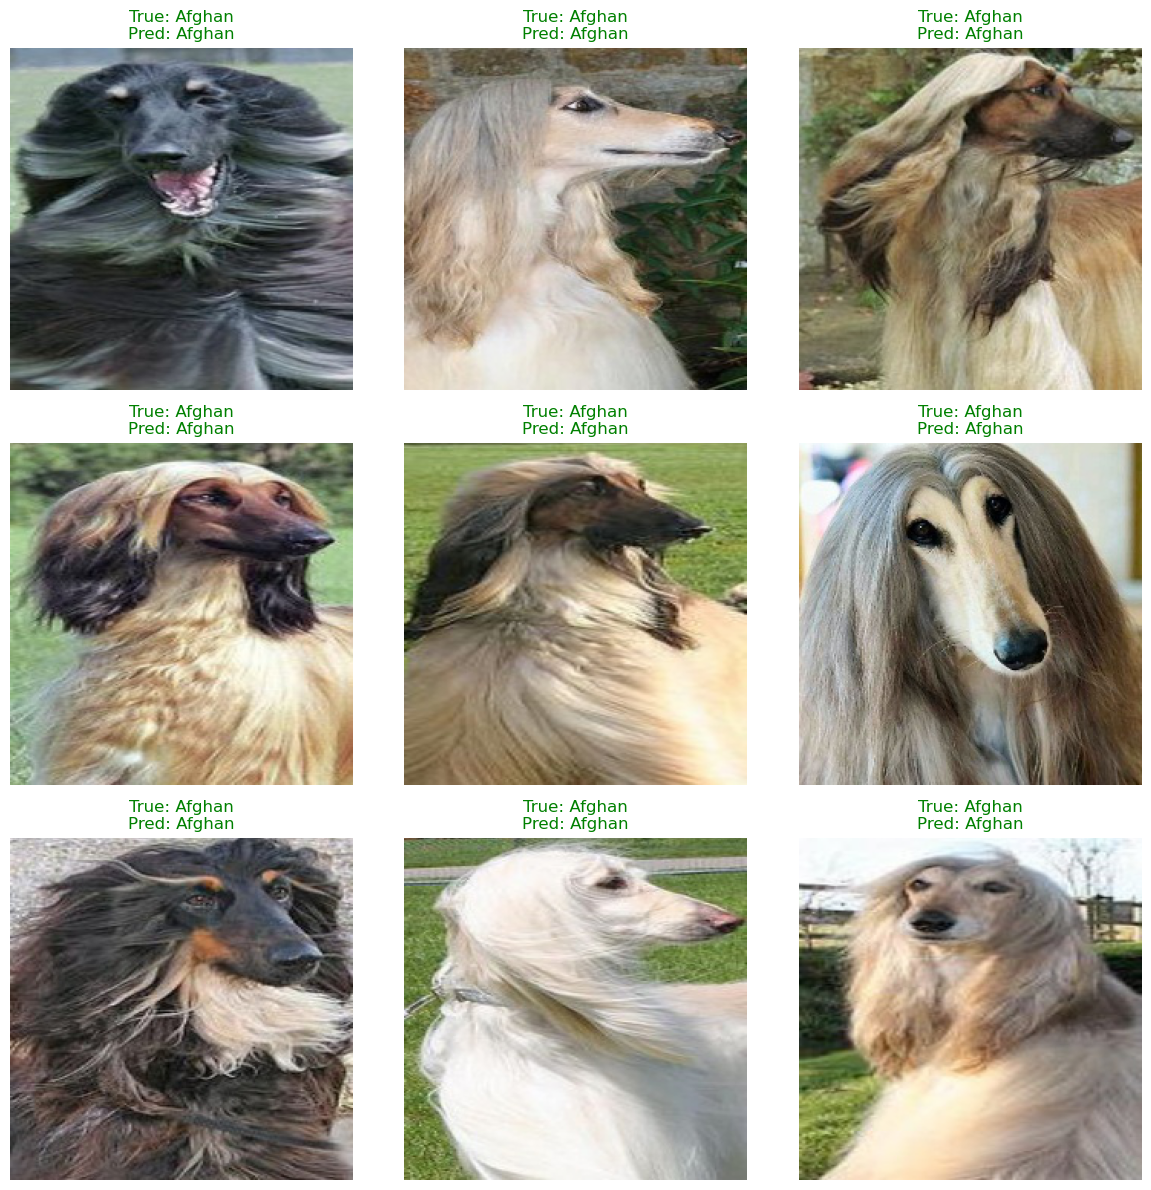

In [24]:
utils.visualize_model_predictions(fine_tuned_model, valid_loader, classes, device, num_images=9)

### 8.3 Analyze Errors

We'll analyze the errors made by the model to identify problematic classes and patterns of confusion.

Analyzing errors: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]


Found 56 errors in 700 samples
Error rate: 0.0800


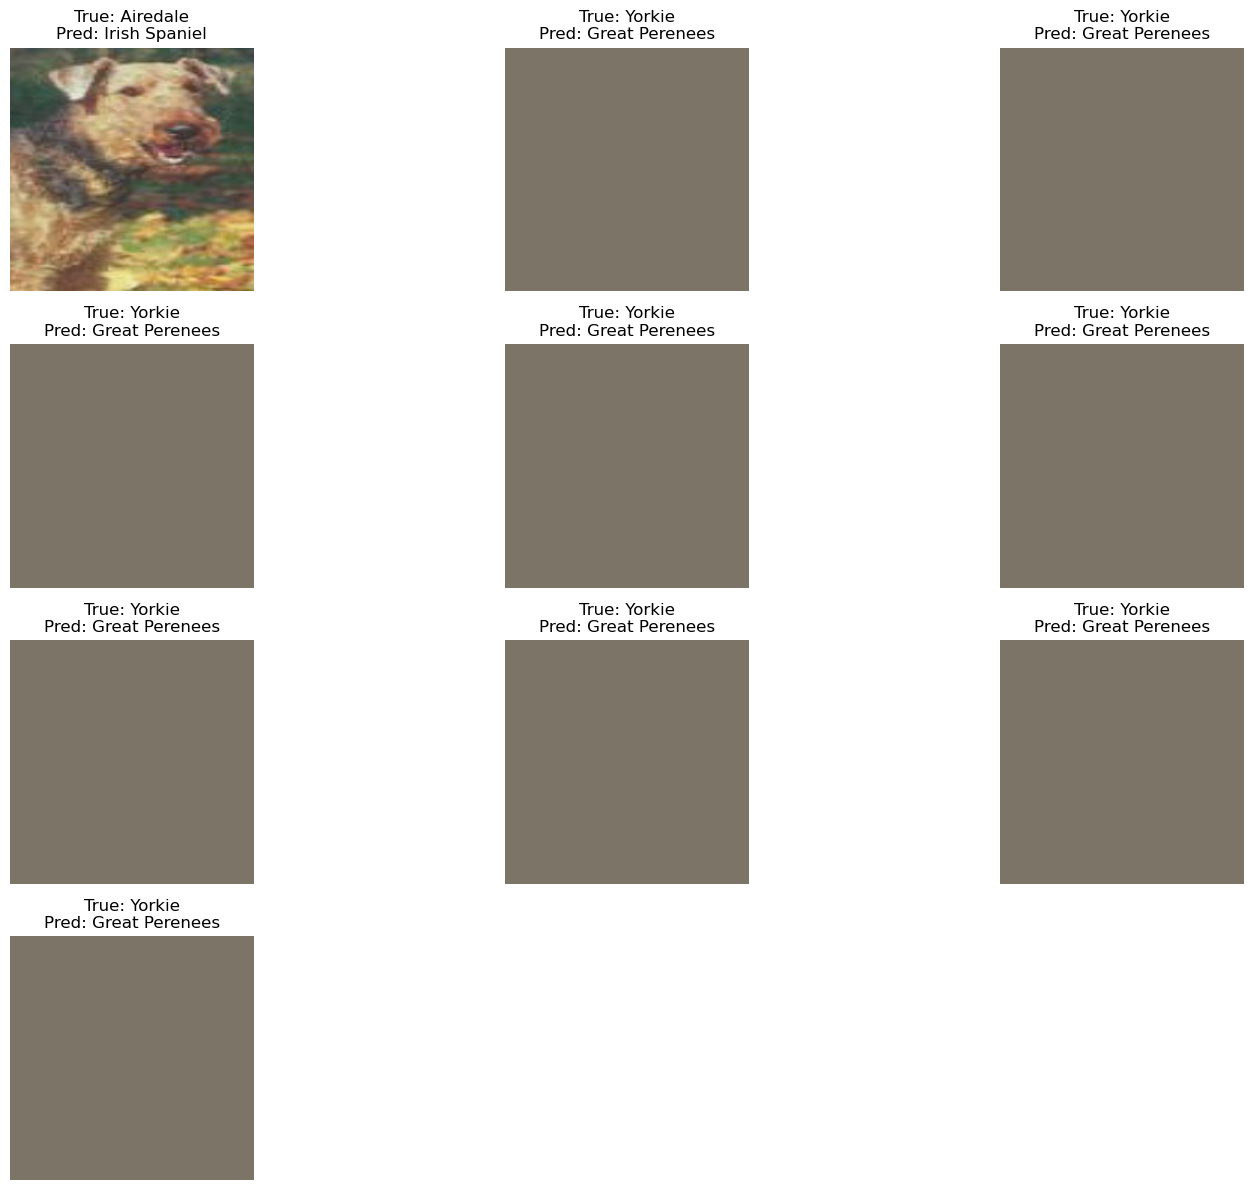

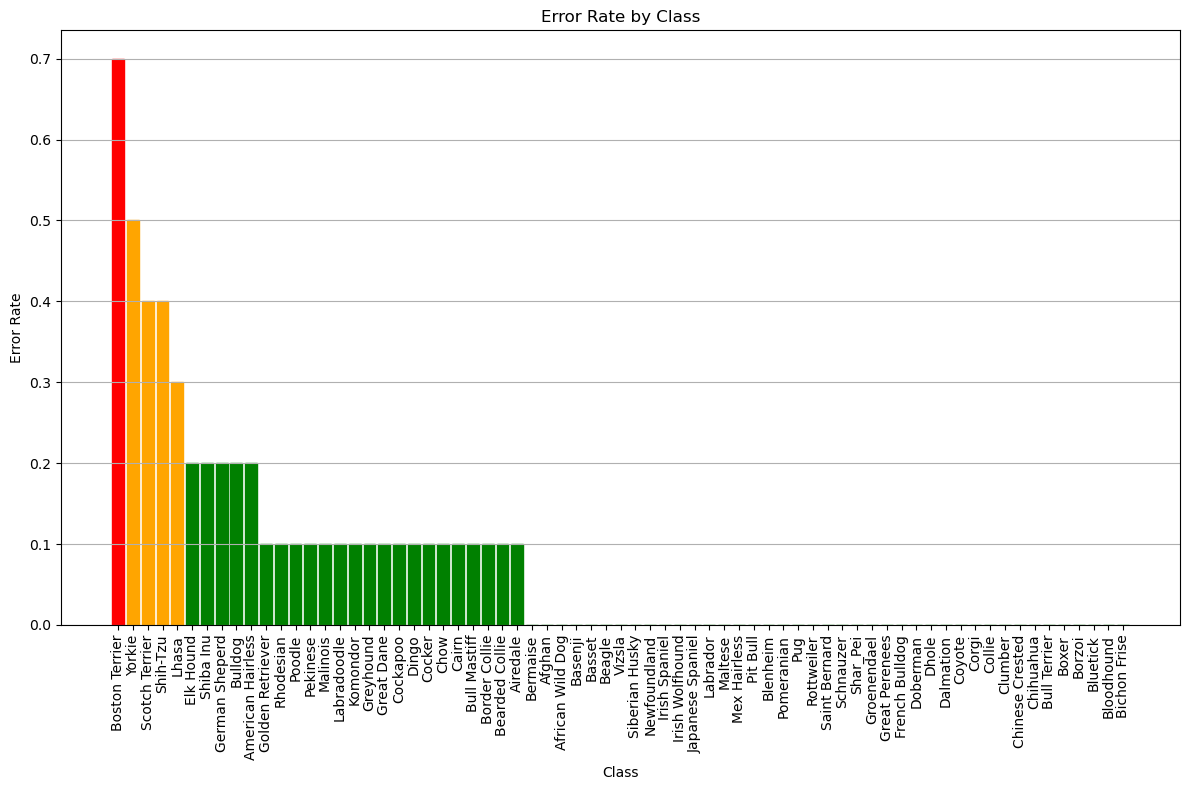

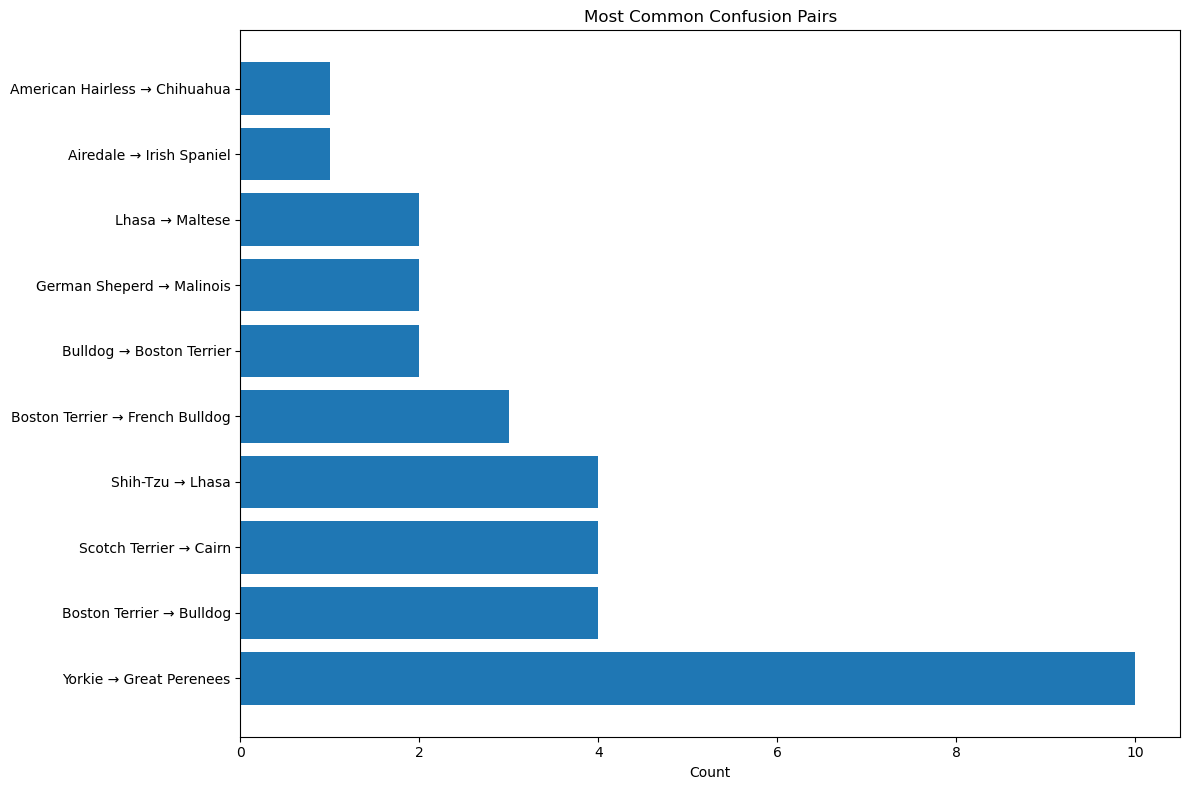

In [25]:
error_analysis = utils.analyze_errors(fine_tuned_model, valid_loader, classes, device, num_samples=10)
utils.plot_error_distribution(error_analysis)
utils.plot_confusion_pairs(error_analysis)

### 8.4 Measure Inference Time

Let's measure how fast the model can make predictions, which is important for real-world applications.

In [26]:
inference_metrics = utils.measure_inference_time(
    fine_tuned_model,
    input_size=(3, 224, 224),
    device=device,
    num_runs=100
)

Average inference time: 4.60 ms
Frames per second: 217.53


## 9. Advanced Visualization and Analysis

To better understand how our model makes decisions, we'll visualize activation maps and class activation maps (CAMs) which highlight important regions the model focuses on for classification.

### 9.1 Visualize Activation Maps

We'll visualize feature maps from the deeper layers to understand what patterns the model is detecting.

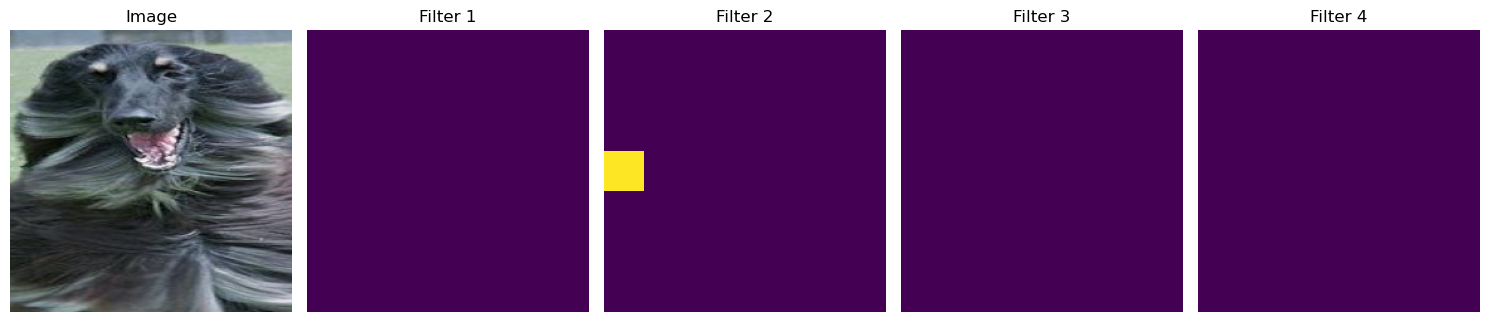

In [27]:
sample_images, sample_labels = next(iter(valid_loader))
sample_image = sample_images[0] 

utils.visualize_activation_maps(fine_tuned_model, sample_image, 'layer4', device)

### 9.2 Generate Class Activation Maps

Class activation maps highlight the regions of the image that most influence the model's prediction for a specific class.

Sample image class: Afghan
Model structure:
Found layer: layer4 (type: Sequential)
Found layer: layer4.0 (type: Bottleneck)
Found layer: layer4.0.conv1 (type: Conv2d)
Found layer: layer4.0.bn1 (type: BatchNorm2d)
Found layer: layer4.0.conv2 (type: Conv2d)
Found layer: layer4.0.bn2 (type: BatchNorm2d)
Found layer: layer4.0.conv3 (type: Conv2d)
Found layer: layer4.0.bn3 (type: BatchNorm2d)
Found layer: layer4.0.relu (type: ReLU)
Found layer: layer4.0.downsample (type: Sequential)
Found layer: layer4.0.downsample.0 (type: Conv2d)
Found layer: layer4.0.downsample.1 (type: BatchNorm2d)
Found layer: layer4.1 (type: Bottleneck)
Found layer: layer4.1.conv1 (type: Conv2d)
Found layer: layer4.1.bn1 (type: BatchNorm2d)
Found layer: layer4.1.conv2 (type: Conv2d)
Found layer: layer4.1.bn2 (type: BatchNorm2d)
Found layer: layer4.1.conv3 (type: Conv2d)
Found layer: layer4.1.bn3 (type: BatchNorm2d)
Found layer: layer4.1.relu (type: ReLU)
Found layer: layer4.2 (type: Bottleneck)
Found layer: layer4.2.c

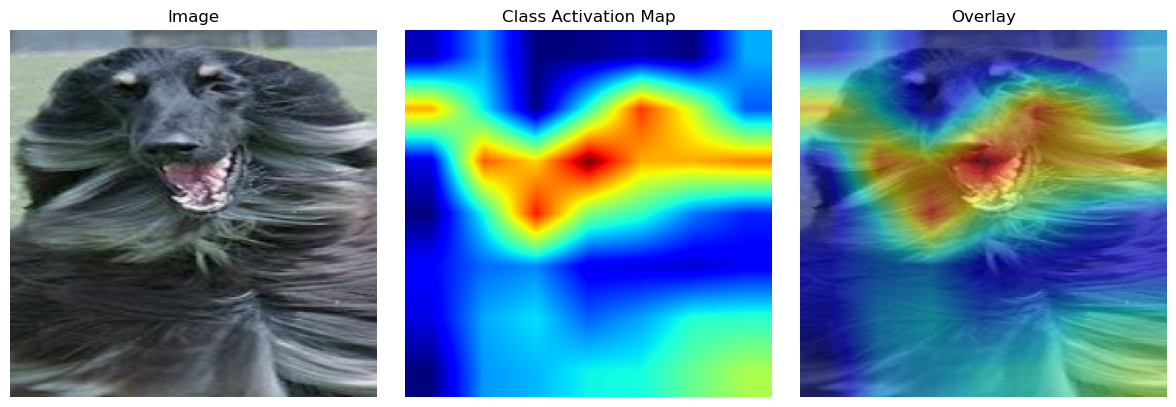

In [28]:
sample_label = sample_labels[0].item()
print(f"Sample image class: {classes[sample_label]}")

utils.visualize_class_activation_maps(fine_tuned_model, sample_image, sample_label, device=device)

## 10. Enhanced Ensemble Models with Multiple Architectures

To improve accuracy, we'll implement an ensemble approach using diverse model architectures. This helps capture different feature representations and reduces overfitting.

### 10.1 Create and Train EfficientNet Model

As a second model for our ensemble, we'll train an EfficientNet B0 model, which has a different architecture from ResNet50.

In [29]:
model_efficientnet = utils.create_model(
    model_name='efficientnet_b0',
    num_classes=len(classes),
    pretrained=True,
    freeze_base=True
)

optimizer_eff = optim.Adam(filter(lambda p: p.requires_grad, model_efficientnet.parameters()), lr=0.001)
scheduler_eff = optim.lr_scheduler.ReduceLROnPlateau(optimizer_eff, mode='min', factor=0.1, patience=2)

eff_model, eff_history = utils.train_or_load_model(
    model_efficientnet,
    {'train_loader': train_loader, 'valid_loader': valid_loader},
    criterion,
    optimizer_eff,
    num_epochs=10,
    scheduler=scheduler_eff,
    device=device,
    checkpoint_path='model_data/efficientnet_model.pth'
)

Epoch 1/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<09:43,  2.39s/it]  

train:   5%|▌         | 13/249 [00:16<02:28,  1.59it/s]

train:   8%|▊         | 21/249 [00:16<01:00,  3.74it/s]

train:  10%|█         | 25/249 [00:16<00:42,  5.27it/s]

train:  13%|█▎        | 32/249 [00:16<00:24,  8.74it/s]

train:  14%|█▍        | 35/249 [00:17<00:19, 10.73it/s]

train:  17%|█▋        | 43/249 [00:17<00:12, 16.10it/s]

train:  19%|█▉        | 47/249 [00:17<00:10, 18.62it/s]

train:  22%|██▏       | 55/249 [00:17<00:08, 22.32it/s]

train:  24%|██▎       | 59/249 [00:17<00:08, 23.48it/s]

train:  27%|██▋       | 67/249 [00:18<00:07, 25.14it/s]

train:  30%|███       | 75/249 [00:18<00:06, 26.69it/s]

train:  32%|███▏      | 79/249 [00:18<00:06, 27.33it/s]

train:  35%|███▍      | 86/249 [00:18<00:05, 28.06it/s]

train:  37%|███▋      | 92/249 [00:19<00:05, 26.99it/s]

train:  40%|████      | 100/249 [00:19<00:05, 27.88it/s]

train:  43%|████▎     | 107/249 [00:19<00:05, 28.30it/s]

train:  45%|████▌     | 113/249 [00:19<00:04, 27.59it/s]

train:  48%|████▊     | 119/249 [00:20<00:04, 27.51it/s]

train:  50%|█████     | 125/249 [00:20<00:04, 26.06it/s]

train:  51%|█████▏    | 128/249 [00:20<00:04, 26.85it/s]

train:  54%|█████▍    | 134/249 [00:20<00:04, 27.83it/s]

train:  56%|█████▌    | 140/249 [00:20<00:03, 27.31it/s]

train:  59%|█████▊    | 146/249 [00:21<00:03, 26.90it/s]

train:  61%|██████    | 152/249 [00:21<00:03, 26.17it/s]

train:  64%|██████▍   | 160/249 [00:21<00:03, 27.33it/s]

train:  66%|██████▌   | 164/249 [00:21<00:03, 27.12it/s]

train:  69%|██████▊   | 171/249 [00:21<00:02, 27.12it/s]

train:  71%|███████   | 177/249 [00:22<00:02, 27.04it/s]

train:  74%|███████▍  | 184/249 [00:22<00:02, 26.38it/s]

train:  76%|███████▌  | 188/249 [00:22<00:02, 27.59it/s]

train:  79%|███████▊  | 196/249 [00:22<00:01, 27.08it/s]

train:  80%|████████  | 200/249 [00:23<00:01, 27.54it/s]

train:  84%|████████▎ | 208/249 [00:23<00:01, 26.42it/s]

train:  85%|████████▌ | 212/249 [00:23<00:01, 26.62it/s]

train:  87%|████████▋ | 216/249 [00:23<00:01, 27.13it/s]

train:  90%|████████▉ | 224/249 [00:23<00:00, 27.38it/s]

train:  93%|█████████▎| 231/249 [00:24<00:00, 27.82it/s]

train:  94%|█████████▍| 234/249 [00:24<00:00, 27.95it/s]

train:  96%|█████████▋| 240/249 [00:24<00:00, 27.18it/s]

train: 100%|█████████▉| 248/249 [00:24<00:00, 29.30it/s]

train: 100%|██████████| 249/249 [00:25<00:00,  9.80it/s]


train Loss: 2.8177 Acc: 0.1773


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  23%|██▎       | 5/22 [00:04<00:12,  1.36it/s]

val:  59%|█████▉    | 13/22 [00:05<00:01,  4.84it/s]

val:  95%|█████████▌| 21/22 [00:05<00:00, 10.17it/s]

val: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s]


val Loss: 4.4212 Acc: 0.0814
Saved best model with accuracy 0.0814

Epoch 2/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<09:48,  2.41s/it]  

train:   5%|▌         | 13/249 [00:16<02:29,  1.58it/s]

train:   8%|▊         | 21/249 [00:16<01:01,  3.68it/s]

train:  10%|█         | 25/249 [00:16<00:44,  5.09it/s]

train:  11%|█         | 28/249 [00:17<00:35,  6.31it/s]

train:  14%|█▍        | 35/249 [00:17<00:21, 10.03it/s]

train:  16%|█▌        | 39/249 [00:17<00:16, 12.60it/s]

train:  17%|█▋        | 43/249 [00:17<00:13, 14.86it/s]

train:  20%|██        | 51/249 [00:17<00:10, 18.45it/s]

train:  22%|██▏       | 55/249 [00:18<00:09, 20.49it/s]

train:  24%|██▎       | 59/249 [00:18<00:08, 21.42it/s]

train:  27%|██▋       | 67/249 [00:18<00:07, 23.11it/s]

train:  29%|██▊       | 71/249 [00:18<00:07, 22.78it/s]

train:  30%|███       | 75/249 [00:18<00:07, 22.91it/s]

train:  33%|███▎      | 83/249 [00:19<00:07, 22.27it/s]

train:  35%|███▍      | 87/249 [00:19<00:07, 22.77it/s]

train:  37%|███▋      | 91/249 [00:19<00:07, 22.51it/s]

train:  40%|███▉      | 99/249 [00:20<00:06, 23.66it/s]

train:  41%|████▏     | 103/249 [00:20<00:06, 24.14it/s]

train:  45%|████▍     | 111/249 [00:20<00:05, 23.94it/s]

train:  46%|████▌     | 115/249 [00:20<00:05, 24.12it/s]

train:  48%|████▊     | 119/249 [00:20<00:05, 23.93it/s]

train:  51%|█████     | 127/249 [00:21<00:05, 23.79it/s]

train:  53%|█████▎    | 131/249 [00:21<00:04, 24.44it/s]

train:  54%|█████▍    | 135/249 [00:21<00:04, 25.37it/s]

train:  57%|█████▋    | 143/249 [00:21<00:04, 25.23it/s]

train:  59%|█████▉    | 147/249 [00:21<00:04, 25.05it/s]

train:  61%|██████    | 151/249 [00:22<00:03, 25.35it/s]

train:  64%|██████▍   | 159/249 [00:22<00:03, 25.40it/s]

train:  65%|██████▌   | 163/249 [00:22<00:03, 25.71it/s]

train:  67%|██████▋   | 167/249 [00:22<00:03, 25.55it/s]

train:  70%|███████   | 175/249 [00:23<00:03, 24.30it/s]

train:  72%|███████▏  | 179/249 [00:23<00:02, 24.73it/s]

train:  73%|███████▎  | 183/249 [00:23<00:02, 23.91it/s]

train:  77%|███████▋  | 191/249 [00:23<00:02, 23.34it/s]

train:  78%|███████▊  | 195/249 [00:23<00:02, 23.66it/s]

train:  82%|████████▏ | 203/249 [00:24<00:01, 24.60it/s]

train:  83%|████████▎ | 207/249 [00:24<00:01, 24.43it/s]

train:  85%|████████▍ | 211/249 [00:24<00:01, 24.24it/s]

train:  88%|████████▊ | 219/249 [00:24<00:01, 23.90it/s]

train:  90%|████████▉ | 223/249 [00:25<00:01, 23.56it/s]

train:  93%|█████████▎| 231/249 [00:25<00:00, 24.97it/s]

train:  94%|█████████▍| 235/249 [00:25<00:00, 24.51it/s]

train:  98%|█████████▊| 243/249 [00:25<00:00, 24.19it/s]

train:  99%|█████████▉| 247/249 [00:26<00:00, 26.09it/s]

train: 100%|██████████| 249/249 [00:26<00:00,  9.34it/s]


train Loss: 2.4697 Acc: 0.2365


val:   5%|▍         | 1/22 [00:04<01:41,  4.81s/it]

val:  32%|███▏      | 7/22 [00:05<00:06,  2.26it/s]

val:  68%|██████▊   | 15/22 [00:05<00:01,  6.58it/s]

val:  86%|████████▋ | 19/22 [00:05<00:00,  9.44it/s]

val: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


val Loss: 4.8943 Acc: 0.0886
Saved best model with accuracy 0.0886

Epoch 3/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:15<09:37,  2.37s/it]  

train:   5%|▌         | 13/249 [00:16<02:26,  1.61it/s]

train:   8%|▊         | 21/249 [00:16<01:00,  3.77it/s]

train:  10%|█         | 25/249 [00:16<00:42,  5.31it/s]

train:  13%|█▎        | 32/249 [00:16<00:24,  8.82it/s]

train:  14%|█▍        | 35/249 [00:16<00:20, 10.53it/s]

train:  16%|█▋        | 41/249 [00:17<00:13, 14.89it/s]

train:  18%|█▊        | 44/249 [00:17<00:12, 16.59it/s]

train:  20%|██        | 51/249 [00:17<00:09, 19.98it/s]

train:  23%|██▎       | 57/249 [00:17<00:08, 23.10it/s]

train:  25%|██▌       | 63/249 [00:18<00:08, 23.14it/s]

train:  28%|██▊       | 69/249 [00:18<00:07, 25.36it/s]

train:  30%|███       | 75/249 [00:18<00:07, 24.51it/s]

train:  32%|███▏      | 79/249 [00:18<00:06, 25.33it/s]

train:  35%|███▍      | 86/249 [00:18<00:06, 25.21it/s]

train:  36%|███▌      | 90/249 [00:19<00:05, 26.77it/s]

train:  39%|███▊      | 96/249 [00:19<00:06, 24.99it/s]

train:  41%|████▏     | 103/249 [00:19<00:05, 25.48it/s]

train:  44%|████▍     | 110/249 [00:19<00:05, 23.73it/s]

train:  46%|████▌     | 114/249 [00:20<00:05, 24.28it/s]

train:  47%|████▋     | 118/249 [00:20<00:05, 24.74it/s]

train:  51%|█████     | 126/249 [00:20<00:05, 24.57it/s]

train:  52%|█████▏    | 130/249 [00:20<00:04, 25.09it/s]

train:  54%|█████▍    | 134/249 [00:20<00:04, 25.51it/s]

train:  57%|█████▋    | 142/249 [00:21<00:04, 23.80it/s]

train:  59%|█████▊    | 146/249 [00:21<00:04, 23.94it/s]

train:  60%|██████    | 150/249 [00:21<00:04, 24.62it/s]

train:  63%|██████▎   | 158/249 [00:21<00:03, 25.96it/s]

train:  67%|██████▋   | 166/249 [00:22<00:03, 26.33it/s]

train:  68%|██████▊   | 170/249 [00:22<00:03, 25.83it/s]

train:  71%|███████▏  | 178/249 [00:22<00:02, 26.31it/s]

train:  73%|███████▎  | 182/249 [00:22<00:02, 26.47it/s]

train:  76%|███████▋  | 190/249 [00:22<00:02, 26.41it/s]

train:  78%|███████▊  | 194/249 [00:23<00:02, 26.37it/s]

train:  81%|████████  | 202/249 [00:23<00:01, 25.93it/s]

train:  83%|████████▎ | 206/249 [00:23<00:01, 25.26it/s]

train:  84%|████████▍ | 210/249 [00:23<00:01, 26.13it/s]

train:  87%|████████▋ | 217/249 [00:24<00:01, 26.43it/s]

train:  90%|████████▉ | 223/249 [00:24<00:01, 24.27it/s]

train:  91%|█████████ | 226/249 [00:24<00:00, 24.47it/s]

train:  93%|█████████▎| 232/249 [00:24<00:00, 25.48it/s]

train:  96%|█████████▌| 238/249 [00:24<00:00, 24.08it/s]

train:  99%|█████████▉| 246/249 [00:25<00:00, 26.06it/s]

train: 100%|██████████| 249/249 [00:25<00:00,  9.61it/s]


train Loss: 2.3508 Acc: 0.2663


val:   5%|▍         | 1/22 [00:04<01:34,  4.51s/it]

val:  32%|███▏      | 7/22 [00:04<00:06,  2.40it/s]

val:  68%|██████▊   | 15/22 [00:05<00:01,  6.96it/s]

val:  86%|████████▋ | 19/22 [00:05<00:00,  9.97it/s]

val: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s]


val Loss: 5.2892 Acc: 0.0814
No improvement for 1 epochs

Epoch 4/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:15<09:38,  2.37s/it]  

train:   5%|▌         | 13/249 [00:16<02:27,  1.60it/s]

train:   7%|▋         | 17/249 [00:16<01:31,  2.54it/s]

train:  10%|█         | 25/249 [00:16<00:43,  5.19it/s]

train:  12%|█▏        | 31/249 [00:16<00:26,  8.14it/s]

train:  14%|█▍        | 35/249 [00:16<00:20, 10.69it/s]

train:  16%|█▋        | 41/249 [00:17<00:14, 14.24it/s]

train:  18%|█▊        | 44/249 [00:17<00:12, 16.40it/s]

train:  20%|██        | 51/249 [00:17<00:10, 19.69it/s]

train:  23%|██▎       | 57/249 [00:17<00:08, 22.10it/s]

train:  24%|██▍       | 60/249 [00:18<00:08, 23.02it/s]

train:  27%|██▋       | 66/249 [00:18<00:07, 23.32it/s]

train:  29%|██▉       | 72/249 [00:18<00:07, 23.02it/s]

train:  30%|███       | 75/249 [00:18<00:07, 23.66it/s]

train:  33%|███▎      | 82/249 [00:18<00:06, 24.79it/s]

train:  35%|███▌      | 88/249 [00:19<00:06, 24.42it/s]

train:  37%|███▋      | 91/249 [00:19<00:06, 24.52it/s]

train:  39%|███▉      | 98/249 [00:19<00:05, 25.96it/s]

train:  42%|████▏     | 105/249 [00:19<00:05, 24.62it/s]

train:  44%|████▍     | 109/249 [00:20<00:05, 24.88it/s]

train:  45%|████▌     | 113/249 [00:20<00:05, 24.00it/s]

train:  49%|████▊     | 121/249 [00:20<00:05, 24.31it/s]

train:  50%|█████     | 125/249 [00:20<00:05, 23.85it/s]

train:  52%|█████▏    | 129/249 [00:20<00:04, 24.68it/s]

train:  55%|█████▌    | 137/249 [00:21<00:04, 25.32it/s]

train:  57%|█████▋    | 141/249 [00:21<00:04, 24.92it/s]

train:  58%|█████▊    | 145/249 [00:21<00:04, 24.55it/s]

train:  61%|██████▏   | 153/249 [00:21<00:03, 24.67it/s]

train:  63%|██████▎   | 157/249 [00:21<00:03, 24.25it/s]

train:  65%|██████▍   | 161/249 [00:22<00:03, 24.23it/s]

train:  66%|██████▋   | 165/249 [00:22<00:03, 25.06it/s]

train:  69%|██████▉   | 173/249 [00:22<00:03, 24.28it/s]

train:  71%|███████   | 177/249 [00:22<00:02, 24.97it/s]

train:  74%|███████▍  | 185/249 [00:23<00:02, 25.22it/s]

train:  76%|███████▌  | 189/249 [00:23<00:02, 25.60it/s]

train:  79%|███████▊  | 196/249 [00:23<00:01, 26.75it/s]

train:  82%|████████▏ | 203/249 [00:23<00:01, 26.04it/s]

train:  83%|████████▎ | 206/249 [00:23<00:01, 26.83it/s]

train:  85%|████████▌ | 212/249 [00:24<00:01, 25.10it/s]

train:  88%|████████▊ | 218/249 [00:24<00:01, 25.41it/s]

train:  90%|████████▉ | 224/249 [00:24<00:01, 24.31it/s]

train:  91%|█████████ | 227/249 [00:24<00:00, 23.58it/s]

train:  94%|█████████▍| 235/249 [00:25<00:00, 24.17it/s]

train:  96%|█████████▌| 239/249 [00:25<00:00, 24.78it/s]

train:  98%|█████████▊| 243/249 [00:25<00:00, 24.55it/s]

train:  99%|█████████▉| 247/249 [00:25<00:00, 26.31it/s]

train: 100%|██████████| 249/249 [00:26<00:00,  9.52it/s]


train Loss: 2.2458 Acc: 0.2785


val:   5%|▍         | 1/22 [00:04<01:34,  4.51s/it]

val:  18%|█▊        | 4/22 [00:04<00:13,  1.34it/s]

val:  55%|█████▍    | 12/22 [00:04<00:01,  6.14it/s]

val:  91%|█████████ | 20/22 [00:05<00:00, 12.74it/s]

val: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s]


val Loss: 5.2668 Acc: 0.0886
No improvement for 2 epochs

Epoch 5/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:15<09:38,  2.37s/it]  

train:   5%|▌         | 13/249 [00:16<02:27,  1.60it/s]

train:   8%|▊         | 21/249 [00:16<01:00,  3.78it/s]

train:  10%|█         | 25/249 [00:16<00:42,  5.31it/s]

train:  13%|█▎        | 32/249 [00:16<00:24,  8.69it/s]

train:  16%|█▌        | 39/249 [00:17<00:15, 13.22it/s]

train:  17%|█▋        | 43/249 [00:17<00:12, 16.14it/s]

train:  20%|██        | 51/249 [00:17<00:09, 20.04it/s]

train:  22%|██▏       | 55/249 [00:17<00:08, 21.90it/s]

train:  25%|██▌       | 63/249 [00:17<00:07, 23.28it/s]

train:  27%|██▋       | 67/249 [00:18<00:07, 24.75it/s]

train:  30%|███       | 75/249 [00:18<00:06, 25.73it/s]

train:  32%|███▏      | 79/249 [00:18<00:06, 26.30it/s]

train:  35%|███▍      | 87/249 [00:18<00:05, 27.56it/s]

train:  38%|███▊      | 95/249 [00:19<00:05, 28.14it/s]

train:  40%|███▉      | 99/249 [00:19<00:05, 27.71it/s]

train:  43%|████▎     | 107/249 [00:19<00:05, 26.72it/s]

train:  45%|████▍     | 111/249 [00:19<00:05, 25.84it/s]

train:  46%|████▌     | 115/249 [00:19<00:05, 25.92it/s]

train:  49%|████▉     | 122/249 [00:20<00:04, 26.81it/s]

train:  51%|█████▏    | 128/249 [00:20<00:04, 24.47it/s]

train:  53%|█████▎    | 131/249 [00:20<00:04, 24.06it/s]

train:  56%|█████▌    | 140/249 [00:20<00:04, 25.42it/s]

train:  57%|█████▋    | 143/249 [00:21<00:04, 24.89it/s]

train:  61%|██████    | 151/249 [00:21<00:03, 26.71it/s]

train:  62%|██████▏   | 155/249 [00:21<00:03, 27.27it/s]

train:  65%|██████▌   | 163/249 [00:21<00:03, 27.26it/s]

train:  67%|██████▋   | 167/249 [00:21<00:03, 26.56it/s]

train:  70%|███████   | 175/249 [00:22<00:02, 26.72it/s]

train:  72%|███████▏  | 179/249 [00:22<00:02, 26.42it/s]

train:  75%|███████▌  | 187/249 [00:22<00:02, 27.22it/s]

train:  77%|███████▋  | 191/249 [00:22<00:02, 27.74it/s]

train:  80%|███████▉  | 199/249 [00:23<00:01, 28.14it/s]

train:  82%|████████▏ | 203/249 [00:23<00:01, 28.36it/s]

train:  85%|████████▍ | 211/249 [00:23<00:01, 28.03it/s]

train:  88%|████████▊ | 219/249 [00:23<00:01, 29.00it/s]

train:  90%|█████████ | 225/249 [00:23<00:00, 27.98it/s]

train:  92%|█████████▏| 229/249 [00:24<00:00, 26.76it/s]

train:  95%|█████████▍| 236/249 [00:24<00:00, 27.29it/s]

train:  98%|█████████▊| 243/249 [00:24<00:00, 27.48it/s]

train:  99%|█████████▉| 247/249 [00:24<00:00, 28.60it/s]

train: 100%|██████████| 249/249 [00:25<00:00,  9.81it/s]


train Loss: 2.1908 Acc: 0.3097


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  23%|██▎       | 5/22 [00:04<00:12,  1.39it/s]

val:  59%|█████▉    | 13/22 [00:05<00:01,  4.91it/s]

val:  95%|█████████▌| 21/22 [00:05<00:00, 10.33it/s]

val: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s]


val Loss: 5.3391 Acc: 0.0957
Saved best model with accuracy 0.0957

Epoch 6/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<09:48,  2.41s/it]  

train:   5%|▌         | 13/249 [00:16<02:29,  1.58it/s]

train:   8%|▊         | 21/249 [00:16<01:01,  3.73it/s]

train:  12%|█▏        | 29/249 [00:16<00:30,  7.21it/s]

train:  13%|█▎        | 33/249 [00:17<00:23,  9.37it/s]

train:  16%|█▌        | 40/249 [00:17<00:15, 13.59it/s]

train:  17%|█▋        | 43/249 [00:17<00:13, 15.27it/s]

train:  20%|██        | 51/249 [00:17<00:09, 19.91it/s]

train:  23%|██▎       | 58/249 [00:17<00:08, 23.67it/s]

train:  25%|██▍       | 62/249 [00:18<00:07, 24.16it/s]

train:  28%|██▊       | 70/249 [00:18<00:07, 24.75it/s]

train:  30%|██▉       | 74/249 [00:18<00:07, 24.27it/s]

train:  31%|███▏      | 78/249 [00:18<00:06, 24.63it/s]

train:  35%|███▍      | 86/249 [00:19<00:06, 24.91it/s]

train:  36%|███▌      | 90/249 [00:19<00:06, 25.65it/s]

train:  38%|███▊      | 94/249 [00:19<00:06, 25.27it/s]

train:  41%|████      | 102/249 [00:19<00:05, 25.03it/s]

train:  43%|████▎     | 106/249 [00:19<00:05, 25.69it/s]

train:  46%|████▌     | 114/249 [00:20<00:05, 25.72it/s]

train:  47%|████▋     | 118/249 [00:20<00:04, 26.39it/s]

train:  51%|█████     | 126/249 [00:20<00:04, 26.04it/s]

train:  52%|█████▏    | 130/249 [00:20<00:04, 26.73it/s]

train:  55%|█████▌    | 138/249 [00:21<00:04, 26.91it/s]

train:  57%|█████▋    | 142/249 [00:21<00:03, 27.61it/s]

train:  60%|██████    | 150/249 [00:21<00:03, 26.87it/s]

train:  62%|██████▏   | 154/249 [00:21<00:03, 25.73it/s]

train:  65%|██████▌   | 162/249 [00:21<00:03, 27.02it/s]

train:  67%|██████▋   | 166/249 [00:22<00:03, 27.48it/s]

train:  70%|██████▉   | 174/249 [00:22<00:02, 25.65it/s]

train:  71%|███████▏  | 178/249 [00:22<00:02, 25.97it/s]

train:  73%|███████▎  | 182/249 [00:22<00:02, 27.15it/s]

train:  76%|███████▋  | 190/249 [00:22<00:02, 28.19it/s]

train:  78%|███████▊  | 194/249 [00:23<00:01, 27.84it/s]

train:  81%|████████  | 202/249 [00:23<00:01, 27.05it/s]

train:  83%|████████▎ | 206/249 [00:23<00:01, 27.44it/s]

train:  86%|████████▌ | 214/249 [00:23<00:01, 27.35it/s]

train:  89%|████████▉ | 222/249 [00:24<00:01, 26.73it/s]

train:  91%|█████████ | 226/249 [00:24<00:00, 27.79it/s]

train:  94%|█████████▍| 234/249 [00:24<00:00, 28.27it/s]

train:  96%|█████████▌| 238/249 [00:24<00:00, 28.21it/s]

train:  99%|█████████▉| 246/249 [00:25<00:00, 28.52it/s]

train: 100%|██████████| 249/249 [00:25<00:00,  9.70it/s]


train Loss: 2.1719 Acc: 0.3061


val:   5%|▍         | 1/22 [00:04<01:38,  4.67s/it]

val:  18%|█▊        | 4/22 [00:04<00:13,  1.29it/s]

val:  55%|█████▍    | 12/22 [00:05<00:01,  5.96it/s]

val:  91%|█████████ | 20/22 [00:05<00:00, 12.46it/s]

val: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s]


val Loss: 5.5106 Acc: 0.0886
No improvement for 1 epochs

Epoch 7/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<09:47,  2.41s/it]  

train:   5%|▌         | 13/249 [00:16<02:29,  1.58it/s]

train:   8%|▊         | 21/249 [00:16<01:01,  3.73it/s]

train:  10%|█         | 25/249 [00:16<00:42,  5.26it/s]

train:  13%|█▎        | 32/249 [00:17<00:24,  8.71it/s]

train:  14%|█▍        | 35/249 [00:17<00:20, 10.46it/s]

train:  17%|█▋        | 43/249 [00:17<00:12, 15.90it/s]

train:  19%|█▉        | 47/249 [00:17<00:11, 18.36it/s]

train:  22%|██▏       | 55/249 [00:17<00:08, 22.04it/s]

train:  24%|██▎       | 59/249 [00:18<00:08, 23.27it/s]

train:  27%|██▋       | 67/249 [00:18<00:07, 25.92it/s]

train:  29%|██▊       | 71/249 [00:18<00:06, 25.87it/s]

train:  32%|███▏      | 79/249 [00:18<00:06, 27.23it/s]

train:  35%|███▍      | 86/249 [00:18<00:05, 27.50it/s]

train:  36%|███▌      | 90/249 [00:19<00:05, 26.90it/s]

train:  38%|███▊      | 94/249 [00:19<00:05, 26.78it/s]

train:  41%|████      | 102/249 [00:19<00:05, 26.82it/s]

train:  44%|████▍     | 110/249 [00:19<00:05, 27.54it/s]

train:  47%|████▋     | 117/249 [00:20<00:04, 27.89it/s]

train:  49%|████▊     | 121/249 [00:20<00:04, 27.88it/s]

train:  52%|█████▏    | 129/249 [00:20<00:04, 27.92it/s]

train:  55%|█████▌    | 137/249 [00:20<00:04, 27.83it/s]

train:  57%|█████▋    | 141/249 [00:20<00:03, 28.15it/s]

train:  60%|█████▉    | 149/249 [00:21<00:03, 27.99it/s]

train:  61%|██████▏   | 153/249 [00:21<00:03, 28.03it/s]

train:  65%|██████▍   | 161/249 [00:21<00:03, 28.30it/s]

train:  67%|██████▋   | 167/249 [00:21<00:03, 26.16it/s]

train:  69%|██████▉   | 173/249 [00:22<00:03, 25.00it/s]

train:  71%|███████   | 177/249 [00:22<00:02, 25.84it/s]

train:  73%|███████▎  | 181/249 [00:22<00:02, 26.46it/s]

train:  76%|███████▌  | 189/249 [00:22<00:02, 25.73it/s]

train:  78%|███████▊  | 193/249 [00:22<00:02, 25.83it/s]

train:  81%|████████  | 201/249 [00:23<00:01, 27.61it/s]

train:  82%|████████▏ | 205/249 [00:23<00:01, 28.40it/s]

train:  85%|████████▍ | 211/249 [00:23<00:01, 27.17it/s]

train:  88%|████████▊ | 218/249 [00:23<00:01, 27.04it/s]

train:  89%|████████▉ | 222/249 [00:24<00:00, 27.07it/s]

train:  92%|█████████▏| 230/249 [00:24<00:00, 27.24it/s]

train:  95%|█████████▌| 237/249 [00:24<00:00, 28.55it/s]

train:  98%|█████████▊| 243/249 [00:24<00:00, 28.86it/s]

train:  99%|█████████▉| 246/249 [00:24<00:00, 27.90it/s]

train: 100%|██████████| 249/249 [00:25<00:00,  9.76it/s]


train Loss: 2.1389 Acc: 0.3136


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  23%|██▎       | 5/22 [00:04<00:12,  1.34it/s]

val:  59%|█████▉    | 13/22 [00:05<00:01,  4.78it/s]

val:  95%|█████████▌| 21/22 [00:05<00:00, 10.10it/s]

val: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s]


val Loss: 5.4957 Acc: 0.0871
No improvement for 2 epochs

Epoch 8/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<09:47,  2.41s/it]  

train:   5%|▌         | 13/249 [00:16<02:29,  1.58it/s]

train:   8%|▊         | 21/249 [00:16<01:01,  3.72it/s]

train:  12%|█▏        | 29/249 [00:16<00:30,  7.11it/s]

train:  13%|█▎        | 32/249 [00:17<00:25,  8.57it/s]

train:  14%|█▍        | 36/249 [00:17<00:19, 10.93it/s]

train:  18%|█▊        | 44/249 [00:17<00:13, 15.75it/s]

train:  19%|█▉        | 48/249 [00:17<00:11, 17.71it/s]

train:  21%|██        | 52/249 [00:17<00:09, 19.87it/s]

train:  24%|██▍       | 60/249 [00:18<00:07, 23.67it/s]

train:  27%|██▋       | 68/249 [00:18<00:07, 24.58it/s]

train:  29%|██▉       | 72/249 [00:18<00:06, 25.51it/s]

train:  32%|███▏      | 80/249 [00:18<00:06, 27.12it/s]

train:  34%|███▎      | 84/249 [00:18<00:06, 27.30it/s]

train:  37%|███▋      | 92/249 [00:19<00:05, 27.23it/s]

train:  39%|███▊      | 96/249 [00:19<00:05, 26.59it/s]

train:  42%|████▏     | 104/249 [00:19<00:05, 27.65it/s]

train:  43%|████▎     | 108/249 [00:19<00:05, 27.69it/s]

train:  47%|████▋     | 116/249 [00:20<00:04, 27.35it/s]

train:  48%|████▊     | 120/249 [00:20<00:04, 27.37it/s]

train:  51%|█████     | 127/249 [00:20<00:04, 27.81it/s]

train:  53%|█████▎    | 133/249 [00:20<00:04, 26.33it/s]

train:  56%|█████▌    | 139/249 [00:21<00:04, 25.81it/s]

train:  59%|█████▉    | 147/249 [00:21<00:03, 26.90it/s]

train:  61%|██████    | 151/249 [00:21<00:03, 27.62it/s]

train:  63%|██████▎   | 157/249 [00:21<00:03, 27.89it/s]

train:  65%|██████▌   | 163/249 [00:21<00:03, 27.40it/s]

train:  68%|██████▊   | 169/249 [00:22<00:02, 26.96it/s]

train:  71%|███████   | 176/249 [00:22<00:02, 28.39it/s]

train:  74%|███████▍  | 184/249 [00:22<00:02, 28.79it/s]

train:  75%|███████▌  | 187/249 [00:22<00:02, 27.88it/s]

train:  78%|███████▊  | 195/249 [00:23<00:01, 27.63it/s]

train:  80%|███████▉  | 199/249 [00:23<00:01, 27.03it/s]

train:  82%|████████▏ | 203/249 [00:23<00:01, 27.23it/s]

train:  85%|████████▍ | 211/249 [00:23<00:01, 26.71it/s]

train:  86%|████████▋ | 215/249 [00:23<00:01, 27.19it/s]

train:  90%|████████▉ | 223/249 [00:24<00:00, 27.09it/s]

train:  91%|█████████ | 227/249 [00:24<00:00, 27.45it/s]

train:  94%|█████████▍| 235/249 [00:24<00:00, 27.92it/s]

train:  98%|█████████▊| 243/249 [00:24<00:00, 28.86it/s]

train:  99%|█████████▉| 247/249 [00:24<00:00, 29.88it/s]

train: 100%|██████████| 249/249 [00:25<00:00,  9.76it/s]


train Loss: 2.1259 Acc: 0.3168


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:   9%|▉         | 2/22 [00:05<00:46,  2.31s/it]

val:  27%|██▋       | 6/22 [00:05<00:08,  1.80it/s]

val:  64%|██████▎   | 14/22 [00:05<00:01,  5.72it/s]

val:  82%|████████▏ | 18/22 [00:06<00:00,  8.29it/s]

val: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]


val Loss: 5.5904 Acc: 0.0843
No improvement for 3 epochs

Epoch 9/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<10:03,  2.47s/it]  

train:   5%|▌         | 13/249 [00:16<02:32,  1.54it/s]

train:   8%|▊         | 21/249 [00:17<01:03,  3.62it/s]

train:  10%|█         | 25/249 [00:17<00:43,  5.10it/s]

train:  12%|█▏        | 31/249 [00:17<00:27,  8.00it/s]

train:  14%|█▎        | 34/249 [00:17<00:21,  9.85it/s]

train:  16%|█▋        | 41/249 [00:17<00:14, 14.43it/s]

train:  18%|█▊        | 44/249 [00:18<00:12, 15.85it/s]

train:  20%|██        | 50/249 [00:18<00:12, 16.58it/s]

train:  21%|██▏       | 53/249 [00:18<00:10, 18.34it/s]

train:  24%|██▎       | 59/249 [00:18<00:09, 19.03it/s]

train:  25%|██▍       | 62/249 [00:18<00:09, 19.82it/s]

train:  27%|██▋       | 68/249 [00:19<00:08, 20.72it/s]

train:  29%|██▊       | 71/249 [00:19<00:08, 20.77it/s]

train:  31%|███▏      | 78/249 [00:19<00:07, 23.36it/s]

train:  33%|███▎      | 82/249 [00:19<00:07, 23.62it/s]

train:  36%|███▌      | 90/249 [00:20<00:06, 24.54it/s]

train:  38%|███▊      | 94/249 [00:20<00:06, 24.35it/s]

train:  39%|███▉      | 98/249 [00:20<00:06, 24.00it/s]

train:  43%|████▎     | 106/249 [00:20<00:05, 24.14it/s]

train:  44%|████▍     | 110/249 [00:20<00:05, 24.18it/s]

train:  46%|████▌     | 114/249 [00:21<00:05, 23.61it/s]

train:  49%|████▉     | 122/249 [00:21<00:05, 23.43it/s]

train:  51%|█████     | 126/249 [00:21<00:05, 24.17it/s]

train:  52%|█████▏    | 130/249 [00:21<00:04, 24.80it/s]

train:  55%|█████▌    | 138/249 [00:22<00:04, 24.29it/s]

train:  57%|█████▋    | 142/249 [00:22<00:04, 24.37it/s]

train:  59%|█████▊    | 146/249 [00:22<00:03, 25.87it/s]

train:  62%|██████▏   | 154/249 [00:22<00:03, 25.07it/s]

train:  63%|██████▎   | 158/249 [00:22<00:03, 25.03it/s]

train:  65%|██████▌   | 162/249 [00:23<00:03, 24.56it/s]

train:  68%|██████▊   | 170/249 [00:23<00:03, 25.31it/s]

train:  70%|██████▉   | 174/249 [00:23<00:02, 25.33it/s]

train:  73%|███████▎  | 182/249 [00:23<00:02, 25.38it/s]

train:  75%|███████▍  | 186/249 [00:23<00:02, 25.42it/s]

train:  76%|███████▋  | 190/249 [00:24<00:02, 23.99it/s]

train:  80%|███████▉  | 198/249 [00:24<00:02, 24.18it/s]

train:  81%|████████  | 202/249 [00:24<00:01, 24.34it/s]

train:  83%|████████▎ | 206/249 [00:24<00:01, 24.07it/s]

train:  84%|████████▍ | 210/249 [00:25<00:01, 24.20it/s]

train:  88%|████████▊ | 218/249 [00:25<00:01, 24.55it/s]

train:  91%|█████████ | 226/249 [00:25<00:00, 25.54it/s]

train:  92%|█████████▏| 230/249 [00:25<00:00, 26.21it/s]

train:  96%|█████████▌| 238/249 [00:26<00:00, 26.22it/s]

train:  97%|█████████▋| 241/249 [00:26<00:00, 26.29it/s]

train:  99%|█████████▉| 247/249 [00:26<00:00, 24.33it/s]

train: 100%|██████████| 249/249 [00:27<00:00,  9.18it/s]


train Loss: 2.1601 Acc: 0.3219


val:   5%|▍         | 1/22 [00:04<01:41,  4.84s/it]

val:  27%|██▋       | 6/22 [00:05<00:07,  2.03it/s]

val:  64%|██████▎   | 14/22 [00:05<00:01,  6.46it/s]

val: 100%|██████████| 22/22 [00:05<00:00, 12.81it/s]

val: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


val Loss: 5.4598 Acc: 0.0900
No improvement for 4 epochs

Epoch 10/10
----------


train:   0%|          | 0/249 [00:00<?, ?it/s]

train:   2%|▏         | 5/249 [00:16<09:59,  2.46s/it]  

train:   5%|▌         | 13/249 [00:16<02:32,  1.55it/s]

train:   8%|▊         | 21/249 [00:16<01:02,  3.66it/s]

train:  10%|█         | 25/249 [00:17<00:43,  5.11it/s]

train:  12%|█▏        | 31/249 [00:17<00:28,  7.75it/s]

train:  14%|█▍        | 35/249 [00:17<00:20, 10.30it/s]

train:  16%|█▌        | 39/249 [00:17<00:16, 12.85it/s]

train:  19%|█▉        | 47/249 [00:18<00:11, 17.39it/s]

train:  22%|██▏       | 54/249 [00:18<00:09, 20.95it/s]

train:  23%|██▎       | 57/249 [00:18<00:08, 21.72it/s]

train:  27%|██▋       | 66/249 [00:18<00:07, 23.94it/s]

train:  28%|██▊       | 69/249 [00:18<00:08, 22.39it/s]

train:  29%|██▉       | 73/249 [00:19<00:07, 22.94it/s]

train:  33%|███▎      | 81/249 [00:19<00:06, 24.39it/s]

train:  35%|███▍      | 87/249 [00:19<00:06, 25.09it/s]

train:  37%|███▋      | 93/249 [00:19<00:06, 24.62it/s]

train:  39%|███▉      | 97/249 [00:20<00:06, 23.49it/s]

train:  41%|████      | 101/249 [00:20<00:06, 24.20it/s]

train:  42%|████▏     | 105/249 [00:20<00:05, 24.14it/s]

train:  45%|████▌     | 113/249 [00:20<00:05, 24.17it/s]

train:  47%|████▋     | 117/249 [00:20<00:05, 23.87it/s]

train:  49%|████▊     | 121/249 [00:21<00:05, 23.10it/s]

train:  52%|█████▏    | 129/249 [00:21<00:04, 25.23it/s]

train:  53%|█████▎    | 133/249 [00:21<00:04, 25.41it/s]

train:  55%|█████▌    | 137/249 [00:21<00:04, 24.40it/s]

train:  58%|█████▊    | 145/249 [00:22<00:04, 23.49it/s]

train:  60%|█████▉    | 149/249 [00:22<00:04, 24.55it/s]

train:  61%|██████▏   | 153/249 [00:22<00:03, 24.99it/s]

train:  63%|██████▎   | 157/249 [00:22<00:03, 25.72it/s]

train:  66%|██████▋   | 165/249 [00:22<00:03, 25.23it/s]

train:  68%|██████▊   | 169/249 [00:22<00:03, 25.08it/s]

train:  71%|███████   | 177/249 [00:23<00:02, 25.53it/s]

train:  73%|███████▎  | 181/249 [00:23<00:02, 26.09it/s]

train:  76%|███████▌  | 189/249 [00:23<00:02, 25.84it/s]

train:  78%|███████▊  | 193/249 [00:23<00:02, 24.65it/s]

train:  79%|███████▉  | 197/249 [00:24<00:02, 23.71it/s]

train:  82%|████████▏ | 205/249 [00:24<00:01, 25.20it/s]

train:  84%|████████▍ | 209/249 [00:24<00:01, 25.50it/s]

train:  87%|████████▋ | 217/249 [00:24<00:01, 25.74it/s]

train:  89%|████████▉ | 221/249 [00:25<00:01, 26.48it/s]

train:  90%|█████████ | 225/249 [00:25<00:00, 26.66it/s]

train:  94%|█████████▎| 233/249 [00:25<00:00, 26.73it/s]

train:  95%|█████████▌| 237/249 [00:25<00:00, 26.43it/s]

train:  98%|█████████▊| 245/249 [00:25<00:00, 26.48it/s]

train: 100%|██████████| 249/249 [00:26<00:00,  9.35it/s]


train Loss: 2.1406 Acc: 0.3101


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  23%|██▎       | 5/22 [00:05<00:12,  1.31it/s]

val:  59%|█████▉    | 13/22 [00:05<00:01,  4.67it/s]

val:  95%|█████████▌| 21/22 [00:05<00:00,  9.87it/s]

val: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s]

val Loss: 5.5837 Acc: 0.0871
No improvement for 5 epochs

Training complete in 5m 21s
Best val Acc: 0.0957


### 10.2 Create and Train DenseNet Model

For even more diversity in our ensemble, we'll add a DenseNet121 model as our third architecture.

In [30]:
model_densenet = utils.create_model(
    model_name='densenet121',
    num_classes=len(classes),
    pretrained=True,
    freeze_base=True
)

optimizer_dense = optim.Adam(filter(lambda p: p.requires_grad, model_densenet.parameters()), lr=0.001)
scheduler_dense = optim.lr_scheduler.ReduceLROnPlateau(optimizer_dense, mode='min', factor=0.1, patience=2)

dense_model, dense_history = utils.train_or_load_model(
    model_densenet,
    {'train_loader': train_loader, 'valid_loader': valid_loader},
    criterion,
    optimizer_dense,
    num_epochs=10,
    scheduler=scheduler_dense,
    device=device,
    checkpoint_path='model_data/densenet_model.pth'
)

Epoch 1/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.35it/s]


train Loss: 2.6810 Acc: 0.3973


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.31s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]


val Loss: 0.9216 Acc: 0.8557
Saved best model with accuracy 0.8557

Epoch 2/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.47it/s]


train Loss: 1.5654 Acc: 0.6111


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.28s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s]


val Loss: 0.5630 Acc: 0.8914
Saved best model with accuracy 0.8914

Epoch 3/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.44it/s]


train Loss: 1.3627 Acc: 0.6464


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.31s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]


val Loss: 0.4407 Acc: 0.9086
Saved best model with accuracy 0.9086

Epoch 4/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.45it/s]


train Loss: 1.2411 Acc: 0.6655


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.36s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]


val Loss: 0.4174 Acc: 0.8886
No improvement for 1 epochs

Epoch 5/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.41it/s]


train Loss: 1.1586 Acc: 0.6790


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:04<00:24,  1.30s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.24it/s]


val Loss: 0.3265 Acc: 0.9157
Saved best model with accuracy 0.9157

Epoch 6/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.40it/s]


train Loss: 1.1222 Acc: 0.6875


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:25,  1.32s/it]

val: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]


val Loss: 0.3490 Acc: 0.9229
Saved best model with accuracy 0.9229

Epoch 7/10
----------


train: 100%|██████████| 249/249 [00:34<00:00,  7.13it/s]


train Loss: 1.1107 Acc: 0.6931


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:07<00:39,  2.07s/it]

val: 100%|██████████| 22/22 [00:10<00:00,  2.18it/s]


val Loss: 0.3242 Acc: 0.9114
No improvement for 1 epochs

Epoch 8/10
----------


train: 100%|██████████| 249/249 [00:34<00:00,  7.29it/s]


train Loss: 1.0759 Acc: 0.6977


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:27,  1.44s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  2.96it/s]


val Loss: 0.3049 Acc: 0.9314
Saved best model with accuracy 0.9314

Epoch 9/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.36it/s]


train Loss: 1.0709 Acc: 0.6971


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:27,  1.44s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


val Loss: 0.3286 Acc: 0.9171
No improvement for 1 epochs

Epoch 10/10
----------


train: 100%|██████████| 249/249 [00:33<00:00,  7.41it/s]


train Loss: 1.0643 Acc: 0.6995


val:   0%|          | 0/22 [00:00<?, ?it/s]

val:  14%|█▎        | 3/22 [00:05<00:27,  1.42s/it]

val: 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]

val Loss: 0.3135 Acc: 0.9229
No improvement for 2 epochs

Training complete in 6m 52s
Best val Acc: 0.9314


### 10.3 Compare Model Performance

Let's plot the training histories of all three models to compare their learning patterns.

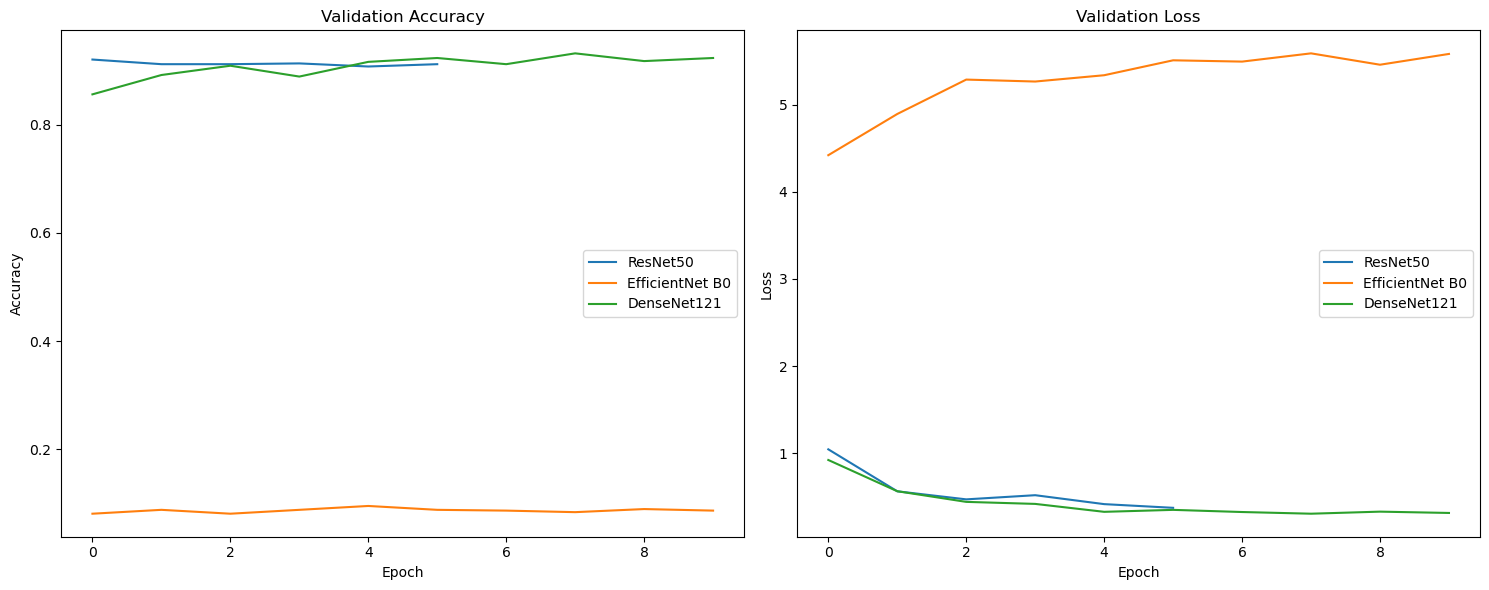

In [31]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(ft_history['val_acc'], label='ResNet50')
plt.plot(eff_history['val_acc'], label='EfficientNet B0')
plt.plot(dense_history['val_acc'], label='DenseNet121')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ft_history['val_loss'], label='ResNet50')
plt.plot(eff_history['val_loss'], label='EfficientNet B0')
plt.plot(dense_history['val_loss'], label='DenseNet121')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 11. Weighted Ensemble with Test-Time Augmentation

We'll now implement a weighted ensemble approach with test-time augmentation (TTA) to further boost performance. The weighted ensemble gives more importance to models that perform better on specific classes, while TTA reduces prediction variance.

### 11.1 Calculate Per-Class Weights for Each Model

We'll calculate how well each model performs on each class and use this information to weight their predictions accordingly.

In [32]:
ensemble_models = [fine_tuned_model, eff_model, dense_model]
class_weights = utils.calculate_model_class_weights(ensemble_models, valid_loader, classes, device)

for model_idx, weights in class_weights.items():
    model_name = ['ResNet50', 'EfficientNet B0', 'DenseNet121'][model_idx]
    print(f"{model_name} average class weight: {weights.mean().item():.4f}")
    
    top_classes = weights.argsort(descending=True)[:5]
    top_class_names = [classes[idx.item()] for idx in top_classes]
    top_weights = [weights[idx].item() for idx in top_classes]
    
    print(f"Top 5 classes for {model_name}:")
    for name, weight in zip(top_class_names, top_weights):
        print(f"  {name}: {weight:.4f}")
    print()

Evaluating model 3/3: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]

ResNet50 average class weight: 1.0000
Top 5 classes for ResNet50:
  Afghan: 1.0870
  African Wild Dog: 1.0870
  Basenji: 1.0870
  Basset: 1.0870
  Beagle: 1.0870

EfficientNet B0 average class weight: 1.0000
Top 5 classes for EfficientNet B0:
  African Wild Dog: 3.1390
  American Hairless: 3.1390
  Basenji: 3.1390
  Beagle: 3.1390
  Bearded Collie: 3.1390

DenseNet121 average class weight: 1.0000
Top 5 classes for DenseNet121:
  Afghan: 1.0736
  African Wild Dog: 1.0736
  Airedale: 1.0736
  Basenji: 1.0736
  Bearded Collie: 1.0736



### 11.2 Create Weighted Ensemble Model

We'll create a weighted ensemble prediction function that can also apply test-time augmentation.

In [33]:
weighted_ensemble_predict = utils.create_weighted_ensemble_model(
    ensemble_models, 
    class_weights=class_weights,
    device=device
)

### 11.3 Evaluate Ensemble Performance With and Without TTA

Let's compare the accuracy of our ensemble with and without test-time augmentation.

In [34]:
ensemble_preds, ensemble_labels = utils.predict_with_tta_ensemble(
    weighted_ensemble_predict, 
    valid_loader, 
    device=device,
    use_tta=False
)

if ensemble_labels is not None:
    ensemble_accuracy = np.mean(ensemble_preds == ensemble_labels)
    print(f"Individual model validation accuracy: {eval_results['accuracy']:.4f}")
    print(f"Weighted ensemble accuracy (without TTA): {ensemble_accuracy:.4f}")

ensemble_preds_tta, ensemble_labels_tta = utils.predict_with_tta_ensemble(
    weighted_ensemble_predict, 
    valid_loader, 
    device=device,
    use_tta=True,
    num_tta=3
)

if ensemble_labels_tta is not None:
    ensemble_accuracy_tta = np.mean(ensemble_preds_tta == ensemble_labels_tta)
    print(f"Weighted ensemble accuracy with TTA: {ensemble_accuracy_tta:.4f}")

Predicting with TTA ensemble: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s]


Individual model validation accuracy: 0.9200
Weighted ensemble accuracy (without TTA): 0.9300


Predicting with TTA ensemble: 100%|██████████| 22/22 [01:10<00:00,  3.22s/it]

Weighted ensemble accuracy with TTA: 0.9529


### 11.4 Analyze TTA Effectiveness by Class

Let's analyze which classes benefit most from test-time augmentation.

In [35]:
if ensemble_labels is not None and ensemble_labels_tta is not None:
    class_acc_no_tta = {}
    class_acc_with_tta = {}
    
    for class_idx in range(len(classes)):
        class_mask = ensemble_labels == class_idx
        if np.sum(class_mask) > 0:
            class_acc_no_tta[class_idx] = np.mean(ensemble_preds[class_mask] == class_idx)
            class_acc_with_tta[class_idx] = np.mean(ensemble_preds_tta[class_mask] == class_idx)
    
    improvements = []
    for class_idx in class_acc_no_tta:
        if class_idx in class_acc_with_tta:
            improvements.append((class_idx, class_acc_with_tta[class_idx] - class_acc_no_tta[class_idx]))
    
    improvements.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 5 classes with largest TTA improvement:")
    for class_idx, improvement in improvements[:5]:
        print(f"{classes[class_idx]}: {improvement:.4f} improvement")
        print(f"  Without TTA: {class_acc_no_tta[class_idx]:.4f}")
        print(f"  With TTA: {class_acc_with_tta[class_idx]:.4f}")


Top 5 classes with largest TTA improvement:
Scotch Terrier: 0.4000 improvement
  Without TTA: 0.6000
  With TTA: 1.0000
Shih-Tzu: 0.2000 improvement
  Without TTA: 0.7000
  With TTA: 0.9000
American Hairless: 0.2000 improvement
  Without TTA: 0.8000
  With TTA: 1.0000
Lhasa: 0.1000 improvement
  Without TTA: 0.7000
  With TTA: 0.8000
Airedale: 0.1000 improvement
  Without TTA: 0.9000
  With TTA: 1.0000


## 12. Generate Final Predictions and Submission

Now we'll use our improved ensemble model with test-time augmentation to make predictions on the test set and create a submission file for the Kaggle competition.

### 12.1 Generate Test Predictions

We'll use our weighted ensemble with test-time augmentation to make predictions on the test set.

In [36]:
ensemble_test_preds, _ = utils.predict_with_tta_ensemble(
    weighted_ensemble_predict, 
    test_loader, 
    device=device,
    use_tta=True,
    num_tta=5
)

test_ids = [entry[0] for entry in utils.predict_on_test_data(fine_tuned_model, test_loader, device)]
ensemble_submission = [(id_val, pred) for id_val, pred in zip(test_ids, ensemble_test_preds)]

Predicting: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


### 12.2 Create and Save Submission File

We'll format our predictions as required by the Kaggle competition and save them to a CSV file.

In [ ]:
ensemble_submission_df = utils.create_submission_file(
    ensemble_submission, 
    idx_to_class, 
    output_path='model_data/submission.csv'
)

display(ensemble_submission_df.head())
print(f"Submission file saved as 'model_data/submission.csv'")

Submission file saved to weighted_ensemble_tta_submission.csv


Id            labels
0   1   'Irish Spaniel'
1   2  'Siberian Husky'
2   3       'Dalmation'
3   4          'Vizsla'
4   5          'Cocker'

Submission file saved as 'weighted_ensemble_tta_submission.csv'


### 12.3 Visualize Test Predictions

Let's visualize some of our test set predictions to qualitatively assess the model's performance.

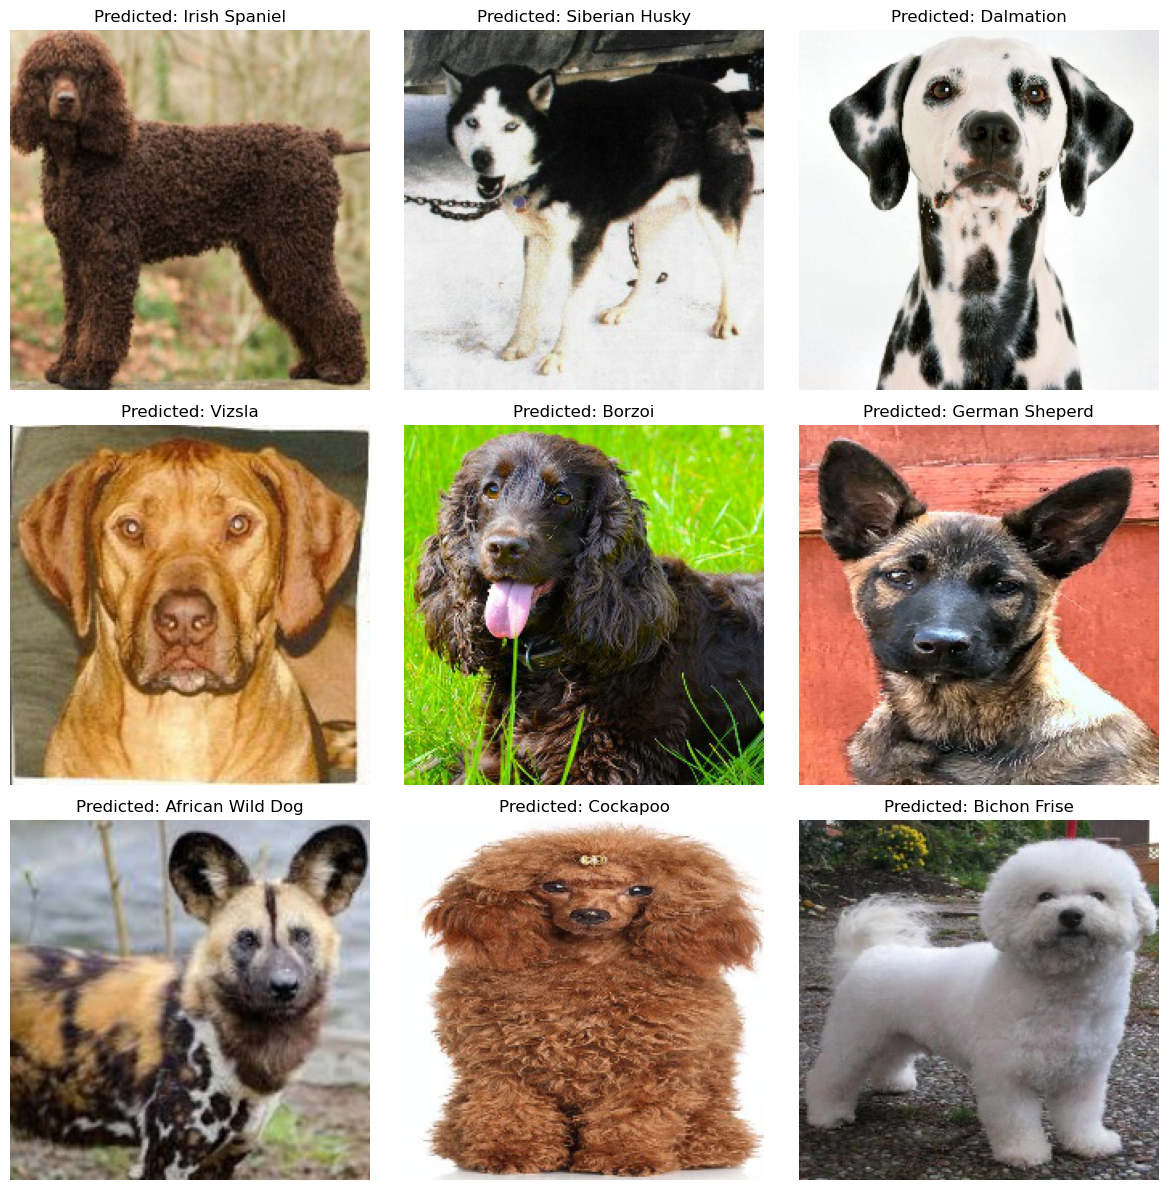

In [38]:
test_images, test_ids = next(iter(test_loader))
test_images = test_images[:9].to(device)

with torch.no_grad():
    test_probs = weighted_ensemble_predict(test_images, use_tta=False)
    _, test_preds = torch.max(test_probs, 1)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, (img, pred) in enumerate(zip(test_images, test_preds)):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    pred_class = classes[pred.item()]
    
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {pred_class}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()